In [2]:
#packages needed

!pip3 install matplotlib numpy pandas seaborn scikit-learn torch tqdm transformers datasets


In [2]:
#to clear cuda (GPU) memory

!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
#restart kernel after

Note to self: there are 5184 texts in the training data: train_data_no_ref.csv, and depending on the batch size, the number of batches pr epoch (number displayed in the tqdm when training the model) will change (e.g. 16 batches will be 324 because 5184/16= 324)




Numbers for splitting train/test to smaller

- Train: 5184
- Test: 1296

1/8 split 
- Train: 5184/8 =648 
- Test: 1296/8=162 

In [5]:
# Investigating (the balance of) our datasets
import pandas as pd

train_data = pd.read_csv("/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/train/train_data_no_ref.csv")

# Count each label
print("train data:")
print(train_data.value_counts(train_data['rep_hateful']))
print(train_data.value_counts(train_data['rep_constructive']))
print(train_data.value_counts(train_data['rep_agree']))


test_data = pd.read_csv("/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/test/test_data_no_ref.csv")

# Count each label
print("test data:")
print(test_data.value_counts(test_data['rep_hateful']))
print(test_data.value_counts(test_data['rep_constructive']))
print(test_data.value_counts(test_data['rep_agree']))


train data:
rep_hateful
Not Hateful               4010
Hateful                    833
Unclassifiable Hateful     341
Name: count, dtype: int64
rep_constructive
Not Constructive               3781
Constructive                   1062
Unclassifiable Constructive     341
Name: count, dtype: int64
rep_agree
Disagree    1936
Agree       1923
Unclear     1325
Name: count, dtype: int64
test data:
rep_hateful
Not Hateful               976
Hateful                   226
Unclassifiable Hateful     94
Name: count, dtype: int64
rep_constructive
Not Constructive               957
Constructive                   238
Unclassifiable Constructive    101
Name: count, dtype: int64
rep_agree
Agree       497
Disagree    439
Unclear     360
Name: count, dtype: int64


## Test: Sci-kit learn multioutput using logistic regression

In [3]:
df = pd.read_csv("/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/train/train_data_no_ref.csv")
print(len(df))

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib

# Split data into features and targets
X = df['rep_text']
y = df[['rep_hateful', 'rep_constructive']]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the pipeline
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', MultiOutputClassifier(LogisticRegression(max_iter=1000)))
])

# Fit the model
text_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = text_clf.predict(X_test)

# Print classification report for each target
for i, label in enumerate(y.columns):
    print(f"Classification report for {label}:")
    print(classification_report(y_test[label], y_pred[:, i]))



# Save the trained model
model_filename = '/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/scikit_classifier_model.joblib'
joblib.dump(text_clf, model_filename)


# Load the trained model
loaded_model = joblib.load(model_filename)


# Sample new unseen data
new_data = pd.Series([
    'i think you should consider your tone, it is hurtful',
    'you are just a stupid girl',
    'lol!'
])

# Predict using the loaded model
new_predictions = loaded_model.predict(new_data)

# Print the predictions
for i, label in enumerate(y.columns):
    print(f"Predictions for {label}:")
    print(new_predictions[:, i])


5184
Classification report for rep_hateful:
                        precision    recall  f1-score   support

               Hateful       0.78      0.12      0.21       243
           Not Hateful       0.81      0.98      0.89      1207
Unclassifiable Hateful       0.64      0.40      0.49       106

              accuracy                           0.80      1556
             macro avg       0.74      0.50      0.53      1556
          weighted avg       0.80      0.80      0.75      1556

Classification report for rep_constructive:
                             precision    recall  f1-score   support

               Constructive       0.94      0.57      0.71       326
           Not Constructive       0.85      0.97      0.90      1125
Unclassifiable Constructive       0.64      0.40      0.49       105

                   accuracy                           0.85      1556
                  macro avg       0.81      0.65      0.70      1556
               weighted avg       0.85      0

# Model without ref

In [2]:
# This is the original code
# Retrain the 01_model_without_reference with a new model (XLM-Roberta)


"""
==============================
Model Training - No Reference
==============================
This script takes our cleaned twitter data and builds a pipeline to fine-tune a BERT which can classify the tweet into its 3 labels classes. 

The label classes are as follows: 
Type (3 labels): Antagonizing, Other political statement, Unclassifiable
Tone Hateful (3 labels):  Hateful, Not Hateful, Unclassifiable Hateful 
Tone Constructive (3 labels): Constructive, Not Constructive, Unclassifiable Constructive

"""

# Data processing 
import pandas as pd
import numpy as np
import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# Modelling 
from transformers import AutoTokenizer, AutoModelForSequenceClassification 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader


def main():
    """
    ==================
    ----- Set Up -----
    ==================
    """
    # -- Parameters -- 
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large") # Change model here if desired
    batch_size = 8 # Small batch number for processing, can increase if using GPU
    num_labels = 12

    # Load Data 
    train_data = pd.read_csv("/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/train/train_data_no_ref.csv")
    test_data = pd.read_csv("/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/test/test_data_no_ref.csv")

    # -- Classes -- 
    class TextDataset(Dataset):
        # initialise the text, labels, the chosen tokenizer (BERT) and set the maximum length to BERT's max (512)
        def __init__(self, texts, labels, tokenizer, max_length=512):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        # Return the total number of instances in the dataset (i.e., the number of rows)
        def __len__(self):
            return len(self.texts)

        # Take the text and labels as indexes, and return a dictonary of the tokenised text and its corresponding label 
        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            encodings = self.tokenizer.encode_plus(
                text,
                padding="max_length",
                truncation=True,
                max_length=self.max_length,
                return_tensors="pt"
            )
            return {"input_ids": encodings["input_ids"][0], 
                    "attention_mask": encodings["attention_mask"][0], 
                    "labels": torch.tensor(label, dtype=torch.float)}

    """
    ==================
    ----- Model -----
    ==================
    """
    # -- Define labels -- 
    mlb = MultiLabelBinarizer(classes=['Antagonizing', 'Other political statement', 'Unclassifiable', 'Hateful', 'Not Hateful', 'Unclassifiable Hateful', 'Constructive', 'Not Constructive','Unclassifiable Constructive', 'Agree', 'Disagree', 'Unclear'])
                                   
    train_labels = mlb.fit_transform(train_data[['rep_type', 'rep_hateful', 'rep_constructive', 'rep_agree']].values)
    test_labels = mlb.transform(test_data[['rep_type', 'rep_hateful', 'rep_constructive', 'rep_agree']].values)

    # -- Create datasets -- 
    train_dataset = TextDataset(train_data['rep_text'].tolist(), train_labels, tokenizer, max_length=512)
    test_dataset = TextDataset(test_data['rep_text'].tolist(), test_labels, tokenizer, max_length=512)

    # create train and test dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    # -- Set the optimizer, loss function and learning rate -- 
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=num_labels)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)

    # -- Training model -- 
    def train(model, dataloader, criterion, optimizer, device):
        model.train()
        model.to(device)
        total_loss = 0
        
        for batch in tqdm(dataloader, desc="Training"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        return avg_loss
    
    # -- Evaluate Function -- 
    def evaluate(model, dataloader, criterion, device):
        model.eval()
        model.to(device)
        total_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Evaluating"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = criterion(logits, labels)
                total_loss += loss.item()

                preds = (logits.sigmoid() > 0.5).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(dataloader)

        return avg_loss, np.array(all_labels), np.array(all_preds)

    """
    ======================
    ----- Test model -----
    ======================
    """
    #  -- Call device --
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # -- Setup saving parameters -- 
    num_epochs = 5
    output_dir = "/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Output/model_without_reference/"
    epoch_no = 0 

    # Define a path to save the model checkpoints
    checkpoint_dir = "/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Output/model_without_reference/checkpoints/"

    # Define the model checkpoint file format (e.g., "model_epoch_{epoch}.pt")
    checkpoint_filename = "model_epoch_{epoch}.pt"

    # Define the label classes
    label_classes = {
        'rep_type': ['Antagonizing', 'Other political statement', 'Unclassifiable'],
        'rep_constructive': ['Constructive', 'Not Constructive', 'Unclassifiable Constructive'],
        'rep_hateful': ['Hateful', 'Not Hateful', 'Unclassifiable Hateful'],
        'rep_agree': ['Agree', 'Disagree', 'Unclear']
    }

    for epoch in range(num_epochs):
        # Free up memory by deleting variables
        epoch_no = epoch_no + 1
        print(f"Epoch {epoch_no}:")

        # -- Train model -- 
        train_loss = train(model, train_dataloader, criterion, optimizer, device)
        print(f"Train Loss: {train_loss}")

        # Save model checkpoint
        checkpoint_path = checkpoint_dir + checkpoint_filename.format(epoch=epoch_no)
        torch.save(model.state_dict(), checkpoint_path)

        # -- Test model -- 
        test_loss, test_true_labels, test_pred_labels = evaluate(model, test_dataloader, criterion, device)
        print(f"Test Loss: {test_loss}")

        # Convert output from one hot encoding 
        true_labels = np.array(test_true_labels)
        pred_labels = np.array(test_pred_labels)

        # Generate confusion matrix
        for class_name, labels in label_classes.items():
            # Get indices corresponding to labels in this class
            indices = [i for i, label in enumerate(mlb.classes_) if label in labels]
            
            # Extract true and predicted values for this class
            class_true = np.argmax(true_labels[:, indices], axis=1)
            class_pred = np.argmax(pred_labels[:, indices], axis=1)
            
            # Compute the confusion matrix
            matrix = confusion_matrix(class_true, class_pred)

            # Save or visualize the confusion matrix
            plt.figure(figsize=(10,10))
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels,
                    yticklabels=labels)
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Confusion Matrix for {class_name}')
            plt.savefig(f'{output_dir}confusion_matrix_{class_name}.png')
            plt.close()

        # Generate report 
        report = classification_report(test_true_labels, 
                                       test_pred_labels, 
                                       target_names=mlb.classes_, 
                                       output_dict=True)
        report_name = output_dir + "classification_report_" + str(epoch_no) + ".txt"

        with open(report_name, "w") as f:
            f.write(classification_report(test_true_labels, test_pred_labels, target_names=mlb.classes_))
        
        # Print results 
        print(f"  Train Loss = {train_loss:.4f}")
        print(f"  Test Loss = {test_loss:.4f}")

main()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:


Training: 100%|██████████| 648/648 [04:01<00:00,  2.68it/s]


Train Loss: 0.44857976489045004


Evaluating: 100%|██████████| 162/162 [00:19<00:00,  8.35it/s]


Test Loss: 0.4097814710787785
  Train Loss = 0.4486
  Test Loss = 0.4098
Epoch 2:


Training: 100%|██████████| 648/648 [04:02<00:00,  2.68it/s]


Train Loss: 0.4452645393709342


Evaluating: 100%|██████████| 162/162 [00:19<00:00,  8.35it/s]


Test Loss: 0.5137574435384186


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Train Loss = 0.4453
  Test Loss = 0.5138
Epoch 3:


Training: 100%|██████████| 648/648 [04:02<00:00,  2.67it/s]


Train Loss: 0.5039357531033917


Evaluating: 100%|██████████| 162/162 [00:19<00:00,  8.35it/s]


Test Loss: 0.5091412348879708


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Train Loss = 0.5039
  Test Loss = 0.5091
Epoch 4:


Training: 100%|██████████| 648/648 [04:02<00:00,  2.67it/s]


Train Loss: 0.5032162866382687


Evaluating: 100%|██████████| 162/162 [00:19<00:00,  8.35it/s]


Test Loss: 0.508584111009115


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Train Loss = 0.5032
  Test Loss = 0.5086
Epoch 5:


Training: 100%|██████████| 648/648 [04:01<00:00,  2.68it/s]


Train Loss: 0.5021157098221191


Evaluating: 100%|██████████| 162/162 [00:19<00:00,  8.35it/s]


Test Loss: 0.50930508180165
  Train Loss = 0.5021
  Test Loss = 0.5093


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# The new code for doing multi output classification on the model without ref 


## --- Imports ---

# Data processing 
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# Modelling 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F


## --- Word definitions ---

# Class: refers to the different ''categories'' of the data. In this case there are 3 classes: 'rep_hateful', 'rep_constructive', 'rep_agree'
# Label: refers to the type of each class. In this case there are 9 labels in total, where a text can have only 1 label for each class, e.g. 'Hateful', 'Not Constructive', 'Disagree'. Thus a text cannot have both the labels 'Hateful' AND 'Not Hateful'!
# Task: refers to the job of solving the classification for each class. In this case the code solves 3 different tasks: 1 is classifying the class 'rep_hateful', 1 for 'rep_constructive' etc.


# Set device, run on gpu if available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the train and test CSV files
train_df = pd.read_csv('/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/train/train_data_no_ref.csv')
test_df = pd.read_csv('/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/test/test_data_no_ref.csv')


# Set tokenizer and batch size
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
batch_size = 32 # Larger batch size: get more “accurate” gradients since optimizing the loss simultaneously over a larger set of texts. However risk of overfitting and slower computing. 32 is a good default size


# Map labels to numeric values for each of the classes 
label_mappings = {
    'rep_hateful': {'Hateful': 0, 'Not Hateful': 1, 'Unclassifiable Hateful': 2},
    'rep_constructive': {'Not Constructive': 0, 'Constructive': 1, 'Unclassifiable Constructive': 2},
    'rep_agree': {'Agree': 0, 'Disagree': 1, 'Unclear': 2}}
for column, mapping in label_mappings.items():
    train_df[column] = train_df[column].map(mapping)
    test_df[column] = test_df[column].map(mapping)


# Directly extract the necessary columns as a numpy array (already encoded as 0, 1, 2)
train_labels = train_df[['rep_hateful', 'rep_constructive', 'rep_agree']].values
test_labels = test_df[['rep_hateful', 'rep_constructive', 'rep_agree']].values


# Define class
class TextDataset(Dataset):
    def __init__(self, texts, labels_hateful, labels_constructive, labels_agree, tokenizer, max_length = 512):
        self.texts = texts
        self.labels_hateful = labels_hateful
        self.labels_constructive = labels_constructive
        self.labels_agree = labels_agree
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts) # Returns the size of the dataset

    def __getitem__(self, idx):
        text = self.texts[idx]
        # Get labels for each class
        label_hateful = self.labels_hateful[idx]
        label_constructive = self.labels_constructive[idx]
        label_agree = self.labels_agree[idx]

        # Tokenize the text
        encodings = self.tokenizer.encode_plus(
            text,
            padding = "max_length",
            truncation = True,
            max_length = self.max_length,
            return_tensors = "pt")

        # Return input tensors and labels for each class
        return {
            "input_ids": encodings["input_ids"].squeeze(),  # Squeeze function converts to the correct shape
            "attention_mask": encodings["attention_mask"].squeeze(),
            "labels_hateful": torch.tensor(label_hateful, dtype = torch.long), # Convert labels into tensor format
            "labels_constructive": torch.tensor(label_constructive, dtype = torch.long), # Long function to get 64-bit integer numbers 
            "labels_agree": torch.tensor(label_agree, dtype = torch.long)}


# Prepare datasets using the TextDataset class we definedd
train_dataset = TextDataset(
    texts = train_df['rep_text'].tolist(),
    labels_hateful = train_labels[:, 0], # Get first column from train_labels array
    labels_constructive = train_labels[:, 1],
    labels_agree = train_labels[:, 2],
    tokenizer = tokenizer)

test_dataset = TextDataset(
    texts = test_df['rep_text'].tolist(),
    labels_hateful = test_labels[:, 0], # Get first column from train_labels array
    labels_constructive = test_labels[:, 1],
    labels_agree = test_labels[:, 2],
    tokenizer = tokenizer)


# Create train and test dataloaders
# Dataset stores the texts and their corresponding labels
# DataLoader wraps an iterable around the Dataset to enable easy access to the texts
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)


# Set model
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels = 9)
# Set criterion: CrossEntropyLoss used for multi output classification
# This criterion computes the cross entropy loss between input logits and target
criterion = nn.CrossEntropyLoss()
# Set optimizer, Adam works well for most tasks
optimizer = optim.AdamW(model.parameters(), lr = 2e-5) # Small learning rate 0.00002 (2e-5) will ensure that the weights of our large pre-trained model dont change too drastically
# A too high lr (e.g. 0.005) will lead to poor results, causing the model to overshoot/fail to converge/generalize poorly


# Define training process. The model is set up as a multi-output classification task where each label is independently predicted
def train(model, dataloader, criterion, optimizer, device):
    model.train() # Set to train mode
    model.to(device) # Allocate model to defined device 
    
    total_loss = 0.0  # Initialize counter for total_loss as a float
    correct_hateful, correct_constructive, correct_agree = 0, 0, 0 # Initialize counter for correctly predicted labels for each class
    total_hateful, total_constructive, total_agree = 0, 0, 0 # Initialize counter for total number of labels for each class
    
    for batch in tqdm(dataloader, desc = "Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_hateful = batch["labels_hateful"].to(device)
        labels_constructive = batch["labels_constructive"].to(device)
        labels_agree = batch["labels_agree"].to(device)
        
        # Clear out the gradients of all parameters that the optimizer is tracking
        optimizer.zero_grad()
        # Calls the forward pass of the model and processes the input data through the layers of the model
        outputs = model(input_ids, attention_mask = attention_mask)
        
        # Extract logits (raw predictions before applying any activation function)
        # Logits will have a shape of [batch_size, 9] since num_labels = 9
        logits = outputs.logits 

        # Now fetch the logits for each label
        # Split the logits into 3 sets of logits (each corresponding to 1 task with 3 labels)
        logits_hateful = logits[:, :3]           # First 3 logits for the "hateful" task
        logits_constructive = logits[:, 3:6]     # Next 3 logits for the "constructive" task
        logits_agree = logits[:, 6:]             # Last 3 logits for the "agree" task

        # Calculate the loss for each class
        # The criterion (CrossEntropyLoss) applies the softmax function internally to the logits. This transforms the raw logits into probabilities that sum to 1 for each example in the batch. 
        # It then calculates the negative log-likelihood loss based on the true labels
        loss_hateful = criterion(logits_hateful, labels_hateful)
        loss_constructive = criterion(logits_constructive, labels_constructive)
        loss_agree = criterion(logits_agree, labels_agree)

        # Combine the losses (average them)
        loss = (loss_hateful + loss_constructive + loss_agree) / 3.0
        
        # Accumulate the loss as a Python float
        total_loss += loss.item()
        
        # Backward pass and optimizer step
        loss.backward()
        optimizer.step() # Makes the optimizer iterate over all parameters (tensors) it is supposed to update and use their internally stored gradients to update their values.

        # Accuracy calculations
        # Predicts the labels for each task by selecting the label with the highest score (logit)
        preds_hateful = torch.argmax(logits_hateful, dim = 1)
        preds_constructive = torch.argmax(logits_constructive, dim = 1)
        preds_agree = torch.argmax(logits_agree, dim = 1)

        # Calculates how many of the predicted labels are correct and then adds that number to the correct_x counter
        correct_hateful += (preds_hateful == labels_hateful).sum().item()
        correct_constructive += (preds_constructive == labels_constructive).sum().item()
        correct_agree += (preds_agree == labels_agree).sum().item()

        # Keeps track of the total number of texts for each classification task
        total_hateful += labels_hateful.size(0) 
        total_constructive += labels_constructive.size(0)
        total_agree += labels_agree.size(0)

    # Calculate average loss for the train data
    avg_loss_train = total_loss / len(dataloader)

    # Calculate accuracy for each task based on number of correctly predicted 
    accuracy_hateful = correct_hateful / total_hateful
    accuracy_constructive = correct_constructive / total_constructive
    accuracy_agree = correct_agree / total_agree

    return avg_loss_train, accuracy_hateful, accuracy_constructive, accuracy_agree

    
# Define evaluation process
def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set to evaluation mode
    model.to(device) # Allocate model to defined device 
    
    total_loss = 0.0  # Initialize counter for total_loss as a float
    correct_hateful, correct_constructive, correct_agree = 0, 0, 0  # Initialize counter for correctly predicted labels for each class
    total_hateful, total_constructive, total_agree = 0, 0, 0 # Initialize counter for total number of labels for each class

    # Initalize empty list to store predicted labels and true labels
    # These will be used in making the classfication reports
    all_preds_hateful, all_preds_constructive, all_preds_agree = [],[],[]
    all_labels_hateful, all_labels_constructive, all_labels_agree = [],[],[]

    with torch.no_grad(): # Temporarily disable gradient calculations during the forward pass
        # Saves memory and computation because the operations don't need to be tracked for backward propagation.
        # This is crucial during evaluation (inference) because we don't need to update the model parameters—just forward pass predictions.
        for batch in tqdm(dataloader, desc = "Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels_hateful = batch["labels_hateful"].to(device)
            labels_constructive = batch["labels_constructive"].to(device)
            labels_agree = batch["labels_agree"].to(device)

            # Calls the forward pass of the model and processes the input data through the layers of the model
            outputs = model(input_ids, attention_mask = attention_mask)
            # Extract logits
            logits = outputs.logits

            # Split the logits for each task
            logits_hateful = logits[:, :3]          
            logits_constructive = logits[:, 3:6] 
            logits_agree = logits[:, 6:]

            # Calculate loss for each task
            loss_hateful = criterion(logits_hateful, labels_hateful)
            loss_constructive = criterion(logits_constructive, labels_constructive)
            loss_agree = criterion(logits_agree, labels_agree)

            # Combine the losses (average them) and store as float
            loss = (loss_hateful + loss_constructive + loss_agree) / 3.0
            total_loss += loss.item()

            # Predicts the labels for each task
            preds_hateful = torch.argmax(logits_hateful, dim=1).cpu().numpy()
            preds_constructive = torch.argmax(logits_constructive, dim=1).cpu().numpy()
            preds_agree = torch.argmax(logits_agree, dim=1).cpu().numpy()

            # Extend the predictions and true labels
            all_preds_hateful.extend(preds_hateful)
            all_preds_constructive.extend(preds_constructive)
            all_preds_agree.extend(preds_agree)

            all_labels_hateful.extend(labels_hateful.cpu().numpy()) # Use labels on CPU for comparison after moving them to device
            all_labels_constructive.extend(labels_constructive.cpu().numpy())
            all_labels_agree.extend(labels_agree.cpu().numpy())

            # Update counts for correctly predicted labels 
            correct_hateful += (preds_hateful == labels_hateful.cpu().numpy()).sum()
            correct_constructive += (preds_constructive == labels_constructive.cpu().numpy()).sum()
            correct_agree += (preds_agree == labels_agree.cpu().numpy()).sum()

            # Update counts for total number of labels for each class 
            total_hateful += labels_hateful.size(0)
            total_constructive += labels_constructive.size(0)
            total_agree += labels_agree.size(0)

    # Calculate average loss for the test data
    avg_loss_test = total_loss / len(dataloader)

    # Calculate accuracy for each task based on number of correctly predicted 
    accuracy_hateful = correct_hateful / total_hateful
    accuracy_constructive = correct_constructive / total_constructive
    accuracy_agree = correct_agree / total_agree

    return (avg_loss_test, 
            np.array(all_labels_hateful), np.array(all_preds_hateful),
            np.array(all_labels_constructive), np.array(all_preds_constructive),
            np.array(all_labels_agree), np.array(all_preds_agree),
            accuracy_hateful, accuracy_constructive, accuracy_agree)


# Call device
model = model.to(device)

# --- Setup saving parameters ---

output_dir = "/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Output/model_without_reference/"

# Define a path to save the model checkpoints
checkpoint_dir = "/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Output/model_without_reference/checkpoints/"

# Define the model checkpoint file format (e.g., "model_epoch_{epoch}.pt")
checkpoint_filename = "model_epoch_{epoch}.pt"



## --- Running model ---

# Define the label classes
label_classes = { 
    'rep_hateful': ['Hateful', 'Not Hateful', 'Unclassifiable Hateful'],
    'rep_constructive': ['Constructive', 'Not Constructive', 'Unclassifiable Constructive'],
    'rep_agree': ['Agree', 'Disagree', 'Unclear']
}

train_losses, test_losses = [], [] # Empty lists for storing losses
train_accuracies, test_accuracies = [], [] # Empty lists for storing accuracies

# Number of epochs
num_epochs = 5 #(starts overfitting (increase in loss + decrease in accuracy) after 4 epochs)
# Continued epochs may well increase training accuracy, but this doesn't necessarily mean the model's predictions from new data will be accurate – often it actually gets worse.
# Initialize counter for epoch number
epoch_no = 0 

for epoch in range(num_epochs):
    epoch_no = epoch + 1
    print(f"Epoch {epoch_no}:")

    # -- Train model -- 
    avg_loss_train, train_acc_hateful, train_acc_constructive, train_acc_agree = train(model, train_dataloader, criterion, optimizer, device)
    train_losses.append(avg_loss_train) # Store training loss
    train_accuracies.append((train_acc_hateful, train_acc_constructive, train_acc_agree)) # Store accuracies for training
    
    # Save model checkpoint
    checkpoint_path = checkpoint_dir + checkpoint_filename.format(epoch = epoch_no)
    torch.save(model.state_dict(), checkpoint_path)
    
    # -- Test model -- 
    avg_loss_test, test_true_labels_hateful, test_pred_labels_hateful,test_true_labels_constructive, test_pred_labels_constructive, test_true_labels_agree, test_pred_labels_agree, test_acc_hateful, test_acc_constructive, test_acc_agree =  evaluate(model, test_dataloader, criterion, device)
    test_losses.append(avg_loss_test) # Store test loss
    test_accuracies.append((test_acc_hateful, test_acc_constructive, test_acc_agree)) # Store accuracies for testing

    # Generate confusion matrix for each class
    for class_name, labels in label_classes.items():
        if class_name == 'rep_hateful':
            class_true = test_true_labels_hateful
            class_pred = test_pred_labels_hateful
        elif class_name == 'rep_constructive':
            class_true = test_true_labels_constructive
            class_pred = test_pred_labels_constructive
        elif class_name == 'rep_agree':
            class_true = test_true_labels_agree
            class_pred = test_pred_labels_agree
            
        # Compute the confusion matrix 
        matrix = confusion_matrix(class_true, class_pred)

        # Plot and save the confusion matrix
        plt.figure(figsize = (10,10))
        sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Blues',
                     xticklabels = labels,
                     yticklabels = labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for {class_name}')
        plt.savefig(f'{output_dir}/confusion_matrix_{class_name}.png')
        plt.close()

    # Generate classification report for each class
    for label in ['constructive', 'agree', 'hateful']:
        if label == 'constructive':
            true_labels = test_true_labels_constructive
            pred_labels = test_pred_labels_constructive
        elif label == 'agree':
            true_labels = test_true_labels_agree
            pred_labels = test_pred_labels_agree
        else:
            true_labels = test_true_labels_hateful
            pred_labels = test_pred_labels_hateful

        report = classification_report(true_labels, 
                                       pred_labels,
                                       target_names = label_classes[f'rep_{label}'], 
                                       output_dict = True)
        
        report_name = output_dir + f"classification_report_{label}_{epoch_no}.txt"
        with open(report_name, "w") as f:
            f.write(classification_report(
                true_labels, pred_labels,
                target_names=label_classes[f'rep_{label}']))

    # Print results 
    print(f"  Train Loss: {avg_loss_train:.4f}, test Loss: {avg_loss_test:.4f}")
    print(f"  Hateful Accuracy: {test_acc_hateful:.4f}, Constructive Accuracy: {test_acc_constructive:.4f}, Agree Accuracy: {test_acc_agree:.4f}")
    print("  Average Accuracy :", round((test_acc_hateful+test_acc_constructive + test_acc_agree)/3,3))


# --- Plotting results ---

plt.figure(figsize = (12,6))

# Loss curve
plt.subplot(1,2,1)
plt.plot(np.arange(1, num_epochs+1), train_losses, label = "Train Loss")
plt.plot(np.arange(1, num_epochs+1), test_losses, label = "Test Loss", linestyle = ":")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(np.arange(1, num_epochs+1)) #show x-axis as integers

# Accuracy on test set (colored by class)
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, num_epochs+1), [x[0] for x in test_accuracies], label = "Test Hateful Accuracy", color = "blue")
plt.plot(np.arange(1, num_epochs+1), [x[1] for x in test_accuracies], label = "Test Constructive Accuracy", color = "green")
plt.plot(np.arange(1, num_epochs+1), [x[2] for x in test_accuracies], label = "Test Agree Accuracy", color = "orange")
plt.title("Test Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(np.arange(1, num_epochs+1)) #show x-axis as integers

# Save and show 
plt.savefig(output_dir+'accuracy_and_loss_curce_plot.png')
plt.tight_layout()
plt.show()



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:


Evaluating: 100%|██████████| 41/41 [00:20<00:00,  2.03it/s]


  Train Loss: 0.7092, test Loss: 0.6148
  Hateful Accuracy: 0.7431, Constructive Accuracy: 0.8642, Agree Accuracy: 0.5725
  Average Accuracy : 0.727
Epoch 2:


Evaluating: 100%|██████████| 41/41 [00:20<00:00,  1.99it/s]


  Train Loss: 0.5392, test Loss: 0.5320
  Hateful Accuracy: 0.8333, Constructive Accuracy: 0.8758, Agree Accuracy: 0.6466
  Average Accuracy : 0.785
Epoch 3:


Evaluating: 100%|██████████| 41/41 [00:20<00:00,  2.00it/s]


  Train Loss: 0.4500, test Loss: 0.5419
  Hateful Accuracy: 0.8364, Constructive Accuracy: 0.8596, Agree Accuracy: 0.6674
  Average Accuracy : 0.788
Epoch 4:


Evaluating: 100%|██████████| 41/41 [00:20<00:00,  1.99it/s]


  Train Loss: 0.3885, test Loss: 0.5856
  Hateful Accuracy: 0.8241, Constructive Accuracy: 0.8472, Agree Accuracy: 0.6782
  Average Accuracy : 0.783
Epoch 5:


Training:  99%|█████████▉| 160/162 [03:44<00:02,  1.40s/it]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:


Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.08it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

  Train Loss: 0.6953, test Loss: 0.6722
  Hateful Accuracy: 0.7531, Constructive Accuracy: 0.7392
  Average Accuracy : 0.746
Epoch 2:


Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.10it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

  Train Loss: 0.5746, test Loss: 0.5320
  Hateful Accuracy: 0.7716, Constructive Accuracy: 0.8549
  Average Accuracy : 0.813
Epoch 3:


Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.09it/s]


  Train Loss: 0.4729, test Loss: 0.4614
  Hateful Accuracy: 0.8171, Constructive Accuracy: 0.8673
  Average Accuracy : 0.842
Epoch 4:


Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.06it/s]


  Train Loss: 0.4039, test Loss: 0.5002
  Hateful Accuracy: 0.8380, Constructive Accuracy: 0.8673
  Average Accuracy : 0.853
Epoch 5:


Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.06it/s]


  Train Loss: 0.3599, test Loss: 0.4443
  Hateful Accuracy: 0.8356, Constructive Accuracy: 0.8619
  Average Accuracy : 0.849


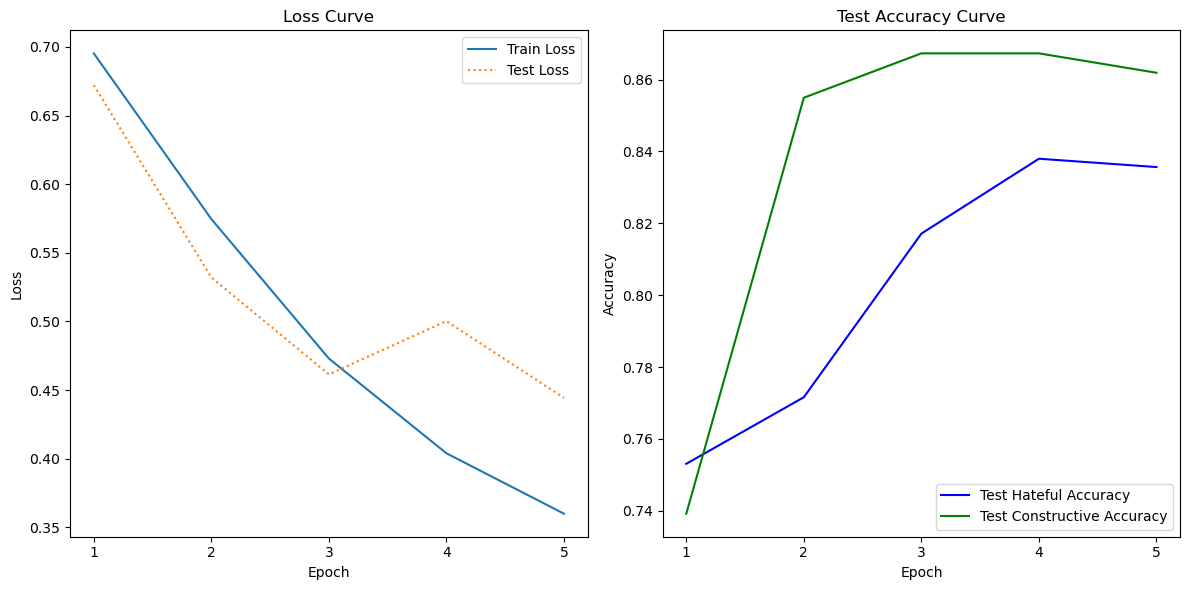

In [3]:
# Model without the agree label


## --- Imports ---

# Data processing 
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# Modelling 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F


## --- Word definitions ---

# Class: refers to the different ''categories'' of the data. In this case there are 2 classes: 'rep_hateful', 'rep_constructive'
# Label: refers to the type of each class. In this case there are 6 labels in total, where a text can have only 1 label for each class, e.g. 'Hateful', 'Not Constructive'. Thus a text cannot have both the labels 'Hateful' AND 'Not Hateful'!
# Task: refers to the job of solving the classification for each class. In this case the code solves 2 different tasks: 1 is classifying the class 'rep_hateful', and 1 for 'rep_constructive' 


# Set device, run on gpu if available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the train and test CSV files
train_df = pd.read_csv('/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/train/train_data_no_ref.csv')
test_df = pd.read_csv('/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/test/test_data_no_ref.csv')


# Set tokenizer and batch size
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
batch_size = 32 # Larger batch size: get more “accurate” gradients since optimizing the loss simultaneously over a larger set of texts. However risk of overfitting and slower computing. 32 is a good default size


# Map labels to numeric values for each of the classes 
label_mappings = {
    'rep_hateful': {'Hateful': 0, 'Not Hateful': 1, 'Unclassifiable Hateful': 2},
    'rep_constructive': {'Not Constructive': 0, 'Constructive': 1, 'Unclassifiable Constructive': 2}}
for column, mapping in label_mappings.items():
    train_df[column] = train_df[column].map(mapping)
    test_df[column] = test_df[column].map(mapping)


# Directly extract the necessary columns as a numpy array (already encoded as 0, 1, 2)
train_labels = train_df[['rep_hateful', 'rep_constructive']].values
test_labels = test_df[['rep_hateful', 'rep_constructive']].values


# Define class
class TextDataset(Dataset):
    def __init__(self, texts, labels_hateful, labels_constructive, tokenizer, max_length = 512):
        self.texts = texts
        self.labels_hateful = labels_hateful
        self.labels_constructive = labels_constructive
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts) # Returns the size of the dataset

    def __getitem__(self, idx):
        text = self.texts[idx]
        # Get labels for each class
        label_hateful = self.labels_hateful[idx]
        label_constructive = self.labels_constructive[idx]

        # Tokenize the text
        encodings = self.tokenizer.encode_plus(
            text,
            padding = "max_length",
            truncation = True,
            max_length = self.max_length,
            return_tensors = "pt")

        # Return input tensors and labels for each class
        return {
            "input_ids": encodings["input_ids"].squeeze(),  # Squeeze function converts to the correct shape
            "attention_mask": encodings["attention_mask"].squeeze(),
            "labels_hateful": torch.tensor(label_hateful, dtype = torch.long), # Convert labels into tensor format
            "labels_constructive": torch.tensor(label_constructive, dtype = torch.long)} # Long function to get 64-bit integer numbers 


# Prepare datasets using the TextDataset class we definedd
train_dataset = TextDataset(
    texts = train_df['rep_text'].tolist(),
    labels_hateful = train_labels[:, 0], # Get first column from train_labels array
    labels_constructive = train_labels[:, 1],
    tokenizer = tokenizer)

test_dataset = TextDataset(
    texts = test_df['rep_text'].tolist(),
    labels_hateful = test_labels[:, 0], # Get first column from train_labels array
    labels_constructive = test_labels[:, 1],
    tokenizer = tokenizer)


# Create train and test dataloaders
# Dataset stores the texts and their corresponding labels
# DataLoader wraps an iterable around the Dataset to enable easy access to the texts
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)


# Set model
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels = 6)
# Set criterion: CrossEntropyLoss used for multi output classification
# This criterion computes the cross entropy loss between input logits and target
criterion = nn.CrossEntropyLoss()
# Set optimizer, Adam works well for most tasks
optimizer = optim.AdamW(model.parameters(), lr = 2e-5) # Small learning rate 0.00002 (2e-5) will ensure that the weights of our large pre-trained model dont change too drastically
# A too high lr (e.g. 0.005) will lead to poor results, causing the model to overshoot/fail to converge/generalize poorly


# Define training process. The model is set up as a multi-output classification task where each label is independently predicted
def train(model, dataloader, criterion, optimizer, device):
    model.train() # Set to train mode
    model.to(device) # Allocate model to defined device 
    
    total_loss = 0.0  # Initialize counter for total_loss as a float
    correct_hateful, correct_constructive = 0, 0 # Initialize counter for correctly predicted labels for each class
    total_hateful, total_constructive = 0, 0 # Initialize counter for total number of labels for each class
    
    for batch in tqdm(dataloader, desc = "Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_hateful = batch["labels_hateful"].to(device)
        labels_constructive = batch["labels_constructive"].to(device)
        
        # Clear out the gradients of all parameters that the optimizer is tracking
        optimizer.zero_grad()
        # Calls the forward pass of the model and processes the input data through the layers of the model
        outputs = model(input_ids, attention_mask = attention_mask)
        
        # Extract logits (raw predictions before applying any activation function)
        # Logits will have a shape of [batch_size, 6] since num_labels = 6
        logits = outputs.logits 

        # Now fetch the logits for each label
        # Split the logits into 2 sets of logits (each corresponding to 1 task with 3 labels)
        logits_hateful = logits[:, :3]           # First 3 logits for the "hateful" task
        logits_constructive = logits[:, 3:6]     # Next 3 logits for the "constructive" task

        # Calculate the loss for each class
        # The criterion (CrossEntropyLoss) applies the softmax function internally to the logits. This transforms the raw logits into probabilities that sum to 1 for each example in the batch. 
        # It then calculates the negative log-likelihood loss based on the true labels
        loss_hateful = criterion(logits_hateful, labels_hateful)
        loss_constructive = criterion(logits_constructive, labels_constructive)

        # Combine the losses (average them)
        loss = (loss_hateful + loss_constructive) / 2.0
        
        # Accumulate the loss as a Python float
        total_loss += loss.item()
        
        # Backward pass and optimizer step
        loss.backward()
        optimizer.step() # Makes the optimizer iterate over all parameters (tensors) it is supposed to update and use their internally stored gradients to update their values.

        # Accuracy calculations
        # Predicts the labels for each task by selecting the label with the highest score (logit)
        preds_hateful = torch.argmax(logits_hateful, dim = 1)
        preds_constructive = torch.argmax(logits_constructive, dim = 1)

        # Calculates how many of the predicted labels are correct and then adds that number to the correct_x counter
        correct_hateful += (preds_hateful == labels_hateful).sum().item()
        correct_constructive += (preds_constructive == labels_constructive).sum().item()

        # Keeps track of the total number of texts for each classification task
        total_hateful += labels_hateful.size(0) 
        total_constructive += labels_constructive.size(0)

    # Calculate average loss for the train data
    avg_loss_train = total_loss / len(dataloader)

    # Calculate accuracy for each task based on number of correctly predicted 
    accuracy_hateful = correct_hateful / total_hateful
    accuracy_constructive = correct_constructive / total_constructive

    return avg_loss_train, accuracy_hateful, accuracy_constructive

    
# Define evaluation process
def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set to evaluation mode
    model.to(device) # Allocate model to defined device 
    
    total_loss = 0.0  # Initialize counter for total_loss as a float
    correct_hateful, correct_constructive = 0, 0  # Initialize counter for correctly predicted labels for each class
    total_hateful, total_constructive = 0, 0 # Initialize counter for total number of labels for each class

    # Initalize empty list to store predicted labels and true labels
    # These will be used in making the classfication reports
    all_preds_hateful, all_preds_constructive = [], []
    all_labels_hateful, all_labels_constructive = [], []

    with torch.no_grad(): # Temporarily disable gradient calculations during the forward pass
        # Saves memory and computation because the operations don't need to be tracked for backward propagation.
        # This is crucial during evaluation (inference) because we don't need to update the model parameters—just forward pass predictions.
        for batch in tqdm(dataloader, desc = "Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels_hateful = batch["labels_hateful"].to(device)
            labels_constructive = batch["labels_constructive"].to(device)

            # Calls the forward pass of the model and processes the input data through the layers of the model
            outputs = model(input_ids, attention_mask = attention_mask)
            # Extract logits
            logits = outputs.logits

            # Split the logits for each task
            logits_hateful = logits[:, :3]          
            logits_constructive = logits[:, 3:6] 

            # Calculate loss for each task
            loss_hateful = criterion(logits_hateful, labels_hateful)
            loss_constructive = criterion(logits_constructive, labels_constructive)

            # Combine the losses (average them) and store as float
            loss = (loss_hateful + loss_constructive) / 2.0
            total_loss += loss.item()

            # Predicts the labels for each task
            preds_hateful = torch.argmax(logits_hateful, dim=1).cpu().numpy()
            preds_constructive = torch.argmax(logits_constructive, dim=1).cpu().numpy()

            # Extend the predictions and true labels
            all_preds_hateful.extend(preds_hateful)
            all_preds_constructive.extend(preds_constructive)

            all_labels_hateful.extend(labels_hateful.cpu().numpy()) # Use labels on CPU for comparison after moving them to device
            all_labels_constructive.extend(labels_constructive.cpu().numpy())

            # Update counts for correctly predicted labels 
            correct_hateful += (preds_hateful == labels_hateful.cpu().numpy()).sum()
            correct_constructive += (preds_constructive == labels_constructive.cpu().numpy()).sum()

            # Update counts for total number of labels for each class 
            total_hateful += labels_hateful.size(0)
            total_constructive += labels_constructive.size(0)

    # Calculate average loss for the test data
    avg_loss_test = total_loss / len(dataloader)

    # Calculate accuracy for each task based on number of correctly predicted 
    accuracy_hateful = correct_hateful / total_hateful
    accuracy_constructive = correct_constructive / total_constructive

    return (avg_loss_test, 
            np.array(all_labels_hateful), np.array(all_preds_hateful),
            np.array(all_labels_constructive), np.array(all_preds_constructive),
            accuracy_hateful, accuracy_constructive)


# Call device
model = model.to(device)

# --- Setup saving parameters ---

output_dir = "/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Output/model_without_reference/"

# Define a path to save the model checkpoints
checkpoint_dir = "/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Output/model_without_reference/checkpoints/"

# Define the model checkpoint file format (e.g., "model_epoch_{epoch}.pt")
checkpoint_filename = "model_epoch_{epoch}.pt"



## --- Running model ---

# Define the label classes
label_classes = { 
    'rep_hateful': ['Hateful', 'Not Hateful', 'Unclassifiable Hateful'],
    'rep_constructive': ['Constructive', 'Not Constructive', 'Unclassifiable Constructive']}

train_losses, test_losses = [], [] # Empty lists for storing losses
train_accuracies, test_accuracies = [], [] # Empty lists for storing accuracies

# Number of epochs
num_epochs = 5 #(starts overfitting (increase in loss + decrease in accuracy) after 4 epochs)
# Continued epochs may well increase training accuracy, but this doesn't necessarily mean the model's predictions from new data will be accurate – often it actually gets worse.
# Initialize counter for epoch number
epoch_no = 0 

for epoch in range(num_epochs):
    epoch_no = epoch + 1
    print(f"Epoch {epoch_no}:")

    # -- Train model -- 
    avg_loss_train, train_acc_hateful, train_acc_constructive = train(model, train_dataloader, criterion, optimizer, device)
    train_losses.append(avg_loss_train) # Store training loss
    train_accuracies.append((train_acc_hateful, train_acc_constructive)) # Store accuracies for training
    
    # Save model checkpoint
    checkpoint_path = checkpoint_dir + checkpoint_filename.format(epoch = epoch_no)
    torch.save(model.state_dict(), checkpoint_path)
    
    # -- Test model -- 
    avg_loss_test, test_true_labels_hateful, test_pred_labels_hateful,test_true_labels_constructive, test_pred_labels_constructive, test_acc_hateful, test_acc_constructive =  evaluate(model, test_dataloader, criterion, device)
    test_losses.append(avg_loss_test) # Store test loss
    test_accuracies.append((test_acc_hateful, test_acc_constructive)) # Store accuracies for testing

    # Generate confusion matrix for each class
    for class_name, labels in label_classes.items():
        if class_name == 'rep_hateful':
            class_true = test_true_labels_hateful
            class_pred = test_pred_labels_hateful
        elif class_name == 'rep_constructive':
            class_true = test_true_labels_constructive
            class_pred = test_pred_labels_constructive
            
        # Compute the confusion matrix 
        matrix = confusion_matrix(class_true, class_pred)

        # Plot and save the confusion matrix
        plt.figure(figsize = (10,10))
        sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Blues',
                     xticklabels = labels,
                     yticklabels = labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for {class_name}')
        plt.savefig(f'{output_dir}/confusion_matrix_{class_name}.png')
        plt.close()

    # Generate classification report for each class
    for label in ['constructive', 'hateful']:
        if label == 'constructive':
            true_labels = test_true_labels_constructive
            pred_labels = test_pred_labels_constructive
        elif label == 'hateful':
            true_labels = test_true_labels_hateful
            pred_labels = test_pred_labels_hateful

        report = classification_report(true_labels, 
                                       pred_labels,
                                       target_names = label_classes[f'rep_{label}'], 
                                       output_dict = True)
        
        report_name = output_dir + f"classification_report_{label}_{epoch_no}.txt"
        with open(report_name, "w") as f:
            f.write(classification_report(
                true_labels, pred_labels,
                target_names=label_classes[f'rep_{label}']))

    # Print results 
    print(f"  Train Loss: {avg_loss_train:.4f}, test Loss: {avg_loss_test:.4f}")
    print(f"  Hateful Accuracy: {test_acc_hateful:.4f}, Constructive Accuracy: {test_acc_constructive:.4f}")
    print("  Average Accuracy :", round((test_acc_hateful+test_acc_constructive)/2,3))



# --- Plotting results ---


plt.figure(figsize = (12,6))

# Loss curve
plt.subplot(1,2,1)
plt.plot(np.arange(1, num_epochs+1), train_losses, label = "Train Loss")
plt.plot(np.arange(1, num_epochs+1), test_losses, label = "Test Loss", linestyle = ":")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(np.arange(1, num_epochs+1)) #show x-axis as integers

# Accuracy on test set (colored by class)
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, num_epochs+1), [x[0] for x in test_accuracies], label = "Test Hateful Accuracy", color = "blue")
plt.plot(np.arange(1, num_epochs+1), [x[1] for x in test_accuracies], label = "Test Constructive Accuracy", color = "green")
plt.title("Test Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(np.arange(1, num_epochs+1)) #show x-axis as integers

# Save and show 
plt.savefig(output_dir+'accuracy_and_loss_curce_plot.png')
plt.tight_layout()
plt.show()


# Model with ref

In [1]:
# This is the original code 

# Retrain the 02_model_with_ref with a new model (XLM-Roberta)

"""
=================================
Model Training 2 - Reference Text
=================================

This script takes our cleaned twitter data and builds a pipeline to fine-tune a BERT which can classify the tweet into its 3 labels classes. 

The label classes are as follows: 
Type (3 labels): Antagonizing, Other political statement, Unclassifiable
Tone Hateful (3 labels):  Hateful, Not Hateful, Unclassifiable Hateful 
Tone Constructive (3 labels): Constructive, Not Constructive, Unclassifiable Constructive

To include the reference tweet information, there is one modification to this model from the basic 'No Reference Model' (01_model_no_ref.py): 
1. The reference text is appended to the reply tweet text with a [SEP] token to delineate the two tweets before the classification is made.
    - This means the model has more information to base its prediction upon as it can see patterns in the reference text and how this may influence the reply tweet text. 

Usage:
  $ python3 src/02_model_with_ref.py

"""

"""
=================================
----- Import Depenendencies -----
=================================
"""
# Data processing 
import pandas as pd
import numpy as np
import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling 
from transformers import AutoTokenizer, XLMRobertaModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

"""
=========================
----- Main Function -----
=========================
"""


def main_4():
    """
    ==========================
    Parameters and Directories 
    ==========================
    """

    # -- Model parameters -- 
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large") # Can change BERT model
    batch_size = 32     # increase to 32 if using GPU
    num_labels = 12
    num_epochs = 5      # Increase if desired, model did not improve after 3. epoch
    epoch_no = 0 

    # -- Directories --
    output_dir = "/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Output/model_with_reference/"
    checkpoint_dir = "/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Output/model_with_reference/checkpoints/" 


    """
    =======
    Classes
    =======
    """
    # create a Dataset class for text and reference labels
    class TextDatasetWithRefLabels(Dataset):
        def __init__(self, ref_texts, ref_labels, texts, labels, tokenizer, max_length):
            self.ref_texts = ref_texts
            self.ref_labels = ref_labels
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

            # Binarize the reference labels
            self.mlb = MultiLabelBinarizer(classes=['Antagonizing', 'Other political statement', 'Unclassifiable', 'Hateful', 'Not Hateful', 'Unclassifiable Hateful', 'Constructive', 'Not Constructive','Unclassifiable Constructive', 'Agree', 'Disagree', 'Unclear'])
            self.ref_labels = self.mlb.fit_transform(ref_labels)

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, index):
            ref_text = self.ref_texts[index]
            ref_label = self.ref_labels[index]
            text = self.texts[index]
            label = self.labels[index]

            # Tokenize the reply tweet 
            rep_tokens = self.tokenizer.tokenize(text)

            # Determine the maximum length of the reference text that can be used 
            max_ref_length = 511 - len(rep_tokens)

            # Tokenize the reference text and truncate if necessary
            ref_tokens = self.tokenizer.tokenize(ref_text)
            if len(ref_tokens) > max_ref_length:
                truncated_ref_tokens = ref_tokens[-max_ref_length:]
            else:
                truncated_ref_tokens = ref_tokens
            
            # Combine the reference and reply text tokens with a [SEP] token
            combined_tokens = truncated_ref_tokens + [self.tokenizer.sep_token] + rep_tokens 

            # Convert the combined tokens to a text string
            combined_text = self.tokenizer.convert_tokens_to_string(combined_tokens)

            # Encode the combined text
            encoded_data = self.tokenizer.encode_plus(
                combined_text,
                add_special_tokens=True,
                max_length=512,
                padding='max_length',
                truncation='only_first',
                return_attention_mask=True,
                return_tensors='pt'
            )

            input_ids = encoded_data['input_ids']
            attention_mask = encoded_data['attention_mask']

            # Convert the label data to tensors
            label_tensor = torch.tensor(label, dtype=torch.float32)
            ref_label_tensor = torch.tensor(ref_label, dtype=torch.float32)

            return {
                'input_ids': input_ids.squeeze(0),
                'attention_mask': attention_mask.squeeze(0),
                'ref_labels': ref_label_tensor,
                'labels': label_tensor
            }

    class RobertaForContextualClassification(nn.Module):
        def __init__(self, num_labels):
            super(RobertaForContextualClassification, self).__init__() 
            self.bert = XLMRobertaModel.from_pretrained('xlm-roberta-large')
            self.dropout = nn.Dropout(0.1)
            self.linear = nn.Linear(self.bert.config.hidden_size, num_labels)

        def forward(self, input_ids, attention_mask, ref_input_ids=None, ref_attention_mask=None):
            if ref_input_ids is not None:
                output = self.bert(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    inputs_embeds=None
                )
            else:
                output = self.bert(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    inputs_embeds=None
                )
            pooled_output = output[1]
            pooled_output = self.dropout(pooled_output)
            logits = self.linear(pooled_output)
            return logits

    """
    =============
    Preprocessing
    =============
    """
    # -- Load Data -- 
    train_data = pd.read_csv('/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/train/train_data_ref.csv')
    test_data = pd.read_csv('/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/test/test_data_ref.csv')

    # prepare the train and test labels using MultiLabelBinarizer
    mlb = MultiLabelBinarizer(classes=['Antagonizing', 'Other political statement', 'Unclassifiable', 'Hateful', 'Not Hateful', 'Unclassifiable Hateful', 'Constructive', 'Not Constructive','Unclassifiable Constructive', 'Agree', 'Disagree', 'Unclear'])

    train_labels = mlb.fit_transform(train_data[['rep_type', 'rep_hateful', 'rep_constructive', 'rep_agree']].values)
    test_labels = mlb.transform(test_data[['rep_type', 'rep_hateful', 'rep_constructive', 'rep_agree']].values)

    # -- create train and test datasets -- 
    train_dataset = TextDatasetWithRefLabels(train_data['ref_text'].tolist(),
                                            train_data[['ref_type', 'ref_hateful', 'ref_constructive']].values,
                                            train_data['rep_text'].tolist(),
                                            train_labels,
                                            tokenizer,
                                            max_length=512)

    test_dataset = TextDatasetWithRefLabels(test_data['ref_text'].tolist(),
                                            test_data[['ref_type', 'ref_hateful', 'ref_constructive']].values,
                                            test_data['rep_text'].tolist(),
                                            test_labels,
                                            tokenizer,
                                            max_length=512)
    
    # create train and test dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    """
    =====
    Model
    =====
    """
    # Initialize the model
    model = RobertaForContextualClassification(num_labels) 

    # Define your optimizer, loss function and learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.BCEWithLogitsLoss()

    # Create training function 
    def train(model, dataloader, criterion, optimizer, device):
        model.train()
        model.to(device)
        total_loss = 0

        for batch in tqdm(dataloader, desc="Training"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            ref_labels = batch["ref_labels"].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        return avg_loss
    
    # -- create evaluation function -- 
    def evaluate(model, dataloader, criterion, device):
        model.eval()
        model.to(device)
        total_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad(): # I added this to temporarily disable gradient calculations during the forward pass (save GPU memory)
            for batch in tqdm(dataloader, desc="Evaluating"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
    
                logits = model(input_ids, attention_mask=attention_mask)
    
                loss = criterion(logits, labels)
                total_loss += loss.item()
    
                preds = (logits.sigmoid() > 0.5).cpu().detach().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().detach().numpy())

        avg_loss = total_loss / len(dataloader)

        return avg_loss, np.array(all_labels), np.array(all_preds)
    

    # Define the model checkpoint file format (e.g., "model_epoch_{epoch}.pt")
    checkpoint_filename = "model_epoch_{epoch}.pt"

    # Define the label classes
    label_classes = {
        'rep_type': ['Antagonizing', 'Other political statement', 'Unclassifiable'],
        'rep_constructive': ['Constructive', 'Not Constructive', 'Unclassifiable Constructive'],
        'rep_hateful': ['Hateful', 'Not Hateful', 'Unclassifiable Hateful'],
        'rep_agree': ['Agree', 'Disagree', 'Unclear']
    }
    
    # -- Wrap it up into a function -- 
    # Call device 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        epoch_no = epoch_no + 1
        print(f"Epoch {epoch_no}:")
        
        # -- Train model -- 
        train_loss = train(model, train_dataloader, criterion, optimizer, device)

        # Save model checkpoint
        checkpoint_path = checkpoint_dir + checkpoint_filename.format(epoch=epoch_no)
        torch.save(model.state_dict(), checkpoint_path)

        # Evaluate the training data 
        # obs here the model is evaluating on the TEST set, often done to to monitor whether the model is learning correctly/identify overfitting early
        # i commented it out because it uses ALOT of memory and is not strictly nessecary
        #train_loss, true_labels, pred_labels = evaluate(model, train_dataloader, criterion, device)

        # -- Test model --
        test_loss, test_true_labels, test_pred_labels = evaluate(model, test_dataloader, criterion, device)

        # Convert output from one hot encoding 
        true_labels = np.array(test_true_labels)
        pred_labels = np.array(test_pred_labels)

        # Generate confusion matrix
        for class_name, labels in label_classes.items():
            # Get indices corresponding to labels in this class
            indices = [i for i, label in enumerate(mlb.classes_) if label in labels]
            
            # Extract true and predicted values for this class
            class_true = np.argmax(true_labels[:, indices], axis=1)
            class_pred = np.argmax(pred_labels[:, indices], axis=1)
            
            # Compute the confusion matrix
            matrix = confusion_matrix(class_true, class_pred)

            # Save or visualize the confusion matrix
            plt.figure(figsize=(10,10))
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels,
                    yticklabels=labels)
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Confusion Matrix for {class_name}')
            plt.savefig(f'{output_dir}confusion_matrix_{class_name}.png')
            plt.close()

        # Generate report 
        report = classification_report(test_true_labels, test_pred_labels, target_names=mlb.classes_, output_dict=True)
        report_name = output_dir + "classification_report_" + str(epoch_no) + ".txt"

        with open(report_name, "w") as f:
            f.write(classification_report(test_true_labels, test_pred_labels, target_names=mlb.classes_))
        
        # Print results 
        print(f"  Train Loss = {train_loss:.4f}")
        print(f"  Test Loss = {test_loss:.4f}")


main_4() 



Epoch 1:


Evaluating: 100%|██████████| 39/39 [00:19<00:00,  2.02it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Train Loss = 0.4799
  Test Loss = 0.3902
Epoch 2:


Evaluating: 100%|██████████| 39/39 [00:19<00:00,  2.01it/s]


  Train Loss = 0.3520
  Test Loss = 0.3302
Epoch 3:


Evaluating: 100%|██████████| 39/39 [00:19<00:00,  2.02it/s]


  Train Loss = 0.2877
  Test Loss = 0.3100
Epoch 4:


Evaluating: 100%|██████████| 39/39 [00:19<00:00,  2.02it/s]


  Train Loss = 0.2318
  Test Loss = 0.3095
Epoch 5:


Evaluating: 100%|██████████| 39/39 [00:19<00:00,  2.00it/s]


  Train Loss = 0.1889
  Test Loss = 0.3481


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:


Evaluating: 100%|██████████| 39/39 [00:20<00:00,  1.95it/s]


  Train Loss: 0.7185, test Loss: 0.5809
  Hateful Accuracy: 0.8121, Constructive Accuracy: 0.8581, Agree Accuracy: 0.6403
  Average Accuracy : 0.77
Epoch 2:


Evaluating: 100%|██████████| 39/39 [00:20<00:00,  1.94it/s]


  Train Loss: 0.5055, test Loss: 0.5116
  Hateful Accuracy: 0.8161, Constructive Accuracy: 0.8694, Agree Accuracy: 0.7008
  Average Accuracy : 0.795
Epoch 3:


Evaluating: 100%|██████████| 39/39 [00:20<00:00,  1.94it/s]


  Train Loss: 0.4160, test Loss: 0.4738
  Hateful Accuracy: 0.8492, Constructive Accuracy: 0.8839, Agree Accuracy: 0.7016
  Average Accuracy : 0.812
Epoch 4:


Evaluating: 100%|██████████| 39/39 [00:20<00:00,  1.94it/s]


  Train Loss: 0.3324, test Loss: 0.5459
  Hateful Accuracy: 0.8371, Constructive Accuracy: 0.8742, Agree Accuracy: 0.6903
  Average Accuracy : 0.801
Epoch 5:


Evaluating: 100%|██████████| 39/39 [00:20<00:00,  1.94it/s]


  Train Loss: 0.2638, test Loss: 0.5820
  Hateful Accuracy: 0.7718, Constructive Accuracy: 0.8879, Agree Accuracy: 0.7121
  Average Accuracy : 0.791


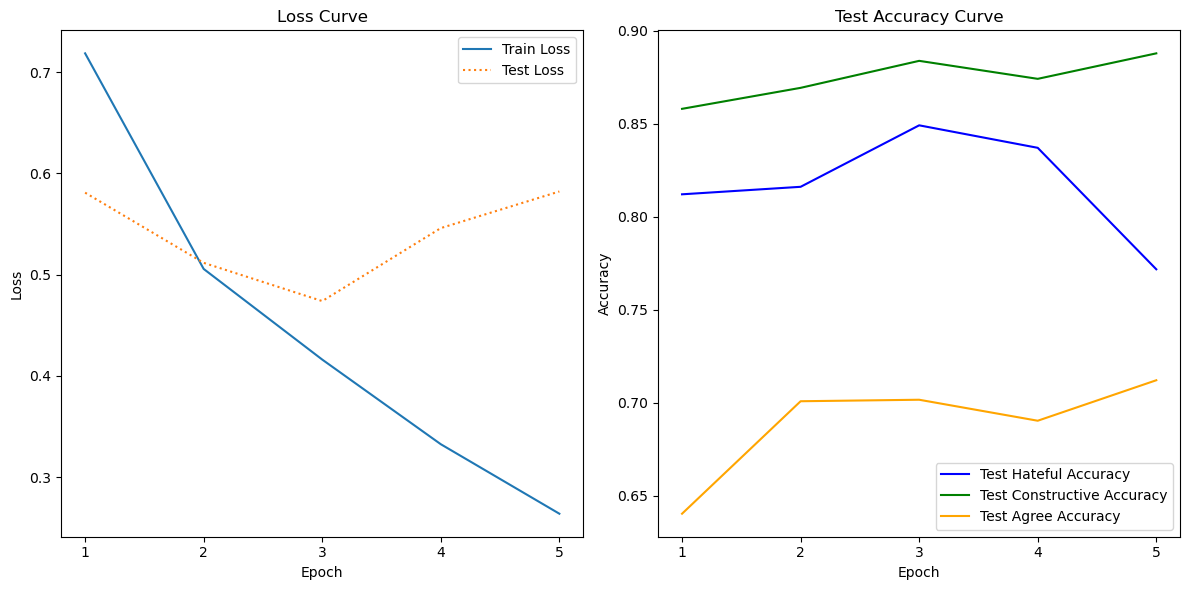

In [4]:
# The new code for doing multi output classification on the model with ref (not using custom model)


## --- Imports ---

# Data processing 
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# Modelling 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F


## --- Word definitions ---

# Class: refers to the different ''categories'' of the data. In this case there are 3 classes: 'rep_hateful', 'rep_constructive', 'rep_agree'
# Label: refers to the type of each class. In this case there are 9 labels in total, where a text can have only 1 label for each class, e.g. 'Hateful', 'Not Constructive', 'Disagree'. Thus a text cannot have both the labels 'Hateful' AND 'Not Hateful'!
# Task: refers to the job of solving the classification for each class. In this case the code solves 3 different tasks: 1 is classifying the class 'rep_hateful', 1 for 'rep_constructive' etc.


# Set device, run on gpu if available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the train and test CSV files
train_df = pd.read_csv('/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/train/train_data_ref.csv')
test_df = pd.read_csv('/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/test/test_data_ref.csv')


# Set tokenizer and batch size
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
batch_size = 32 # Larger batch size: get more “accurate” gradients since optimizing the loss simultaneously over a larger set of texts. However risk of overfitting and slower computing. 32 is a good default size


# Map labels to numeric values for each of the classes 
label_mappings = {
    'rep_hateful': {'Hateful': 0, 'Not Hateful': 1, 'Unclassifiable Hateful': 2},
    'rep_constructive': {'Not Constructive': 0, 'Constructive': 1, 'Unclassifiable Constructive': 2},
    'rep_agree': {'Agree': 0, 'Disagree': 1, 'Unclear': 2}}
for column, mapping in label_mappings.items():
    train_df[column] = train_df[column].map(mapping)
    test_df[column] = test_df[column].map(mapping)


# Directly extract the necessary columns as a numpy array (already encoded as 0, 1, 2)
train_labels = train_df[['rep_hateful', 'rep_constructive', 'rep_agree']].values
test_labels = test_df[['rep_hateful', 'rep_constructive', 'rep_agree']].values


# Define class
class TextDataset(Dataset):
    def __init__(self, texts, ref_texts, labels_hateful, labels_constructive, labels_agree, tokenizer, max_length = 512):
        self.texts = texts
        self.ref_texts = ref_texts
        self.labels_hateful = labels_hateful
        self.labels_constructive = labels_constructive
        self.labels_agree = labels_agree
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts) # Returns the size of the dataset

    def __getitem__(self, idx):
        text = self.texts[idx]
        ref_text = self.ref_texts[idx]
        # Get labels for each class
        label_hateful = self.labels_hateful[idx]
        label_constructive = self.labels_constructive[idx]
        label_agree = self.labels_agree[idx]

        # Tokenize the reply tweet 
        rep_tokens = self.tokenizer.tokenize(text)

        # Determine the maximum length of the reference text that can be used 
        max_ref_length = 511 - len(rep_tokens)

        # Tokenize the reference text and truncate if necessary
        ref_tokens = self.tokenizer.tokenize(ref_text)
        if len(ref_tokens) > max_ref_length:
            truncated_ref_tokens = ref_tokens[-max_ref_length:]
        else:
            truncated_ref_tokens = ref_tokens

        # Combine the reference and reply text tokens with a [SEP] token
        combined_tokens = truncated_ref_tokens + [self.tokenizer.sep_token] + rep_tokens 

        # Convert the combined tokens to a text string
        combined_text = self.tokenizer.convert_tokens_to_string(combined_tokens)
        
        # Encode the combined text
        encoded_data = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True, 
            max_length=512,
            padding='max_length',
            truncation='only_first',
            return_attention_mask=True, 
            return_tensors='pt')

        # Return input tensors and labels for each class
        return {
            "input_ids": encoded_data["input_ids"].squeeze(),  # Squeeze function converts to the correct shape
            "attention_mask": encoded_data["attention_mask"].squeeze(),
            "labels_hateful": torch.tensor(label_hateful, dtype = torch.long), # Convert labels into tensor format
            "labels_constructive": torch.tensor(label_constructive, dtype = torch.long), # Long function to get 64-bit integer numbers 
            "labels_agree": torch.tensor(label_agree, dtype = torch.long)}


# Prepare datasets using the TextDataset class we definedd
train_dataset = TextDataset(
    texts = train_df['rep_text'].tolist(),
    ref_texts = train_df['ref_text'].tolist(),
    labels_hateful = train_labels[:, 0], # Get first column from train_labels array
    labels_constructive = train_labels[:, 1],
    labels_agree = train_labels[:, 2],
    tokenizer = tokenizer)

test_dataset = TextDataset(
    texts = test_df['rep_text'].tolist(),
    ref_texts = test_df['ref_text'].tolist(),
    labels_hateful = test_labels[:, 0], # Get first column from train_labels array
    labels_constructive = test_labels[:, 1],
    labels_agree = test_labels[:, 2],
    tokenizer = tokenizer)


# Create train and test dataloaders
# Dataset stores the texts and their corresponding labels
# DataLoader wraps an iterable around the Dataset to enable easy access to the texts
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)


# Set model
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels = 9)
# Set criterion: CrossEntropyLoss used for multi output classification
# This criterion computes the cross entropy loss between input logits and target
criterion = nn.CrossEntropyLoss()
# Set optimizer, Adam works well for most tasks
optimizer = optim.AdamW(model.parameters(), lr = 2e-5) # Small learning rate 0.00002 (2e-5) will ensure that the weights of our large pre-trained model dont change too drastically
# A too high lr (e.g. 0.005) will lead to poor results, causing the model to overshoot/fail to converge/generalize poorly


# Define training process. The model is set up as a multi-output classification task where each label is independently predicted
def train(model, dataloader, criterion, optimizer, device):
    model.train() # Set to train mode
    model.to(device) # Allocate model to defined device 
    
    total_loss = 0.0  # Initialize counter for total_loss as a float
    correct_hateful, correct_constructive, correct_agree = 0, 0, 0 # Initialize counter for correctly predicted labels for each class
    total_hateful, total_constructive, total_agree = 0, 0, 0 # Initialize counter for total number of labels for each class
    
    for batch in tqdm(dataloader, desc = "Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_hateful = batch["labels_hateful"].to(device)
        labels_constructive = batch["labels_constructive"].to(device)
        labels_agree = batch["labels_agree"].to(device)
        
        # Clear out the gradients of all parameters that the optimizer is tracking
        optimizer.zero_grad()
        # Calls the forward pass of the model and processes the input data through the layers of the model
        outputs = model(input_ids, attention_mask = attention_mask)
        
        # Extract logits (raw predictions before applying any activation function)
        # Logits will have a shape of [batch_size, 9] since num_labels = 9
        logits = outputs.logits 

        # Now fetch the logits for each label
        # Split the logits into 3 sets of logits (each corresponding to 1 task with 3 labels)
        logits_hateful = logits[:, :3]           # First 3 logits for the "hateful" task
        logits_constructive = logits[:, 3:6]     # Next 3 logits for the "constructive" task
        logits_agree = logits[:, 6:]             # Last 3 logits for the "agree" task

        # Calculate the loss for each class
        # The criterion (CrossEntropyLoss) applies the softmax function internally to the logits. This transforms the raw logits into probabilities that sum to 1 for each example in the batch. 
        # It then calculates the negative log-likelihood loss based on the true labels
        loss_hateful = criterion(logits_hateful, labels_hateful)
        loss_constructive = criterion(logits_constructive, labels_constructive)
        loss_agree = criterion(logits_agree, labels_agree)

        # Combine the losses (average them)
        loss = (loss_hateful + loss_constructive + loss_agree) / 3.0
        
        # Accumulate the loss as a Python float
        total_loss += loss.item()
        
        # Backward pass and optimizer step
        loss.backward()
        optimizer.step() # Makes the optimizer iterate over all parameters (tensors) it is supposed to update and use their internally stored gradients to update their values.

        # Accuracy calculations
        # Predicts the labels for each task by selecting the label with the highest score (logit)
        preds_hateful = torch.argmax(logits_hateful, dim = 1)
        preds_constructive = torch.argmax(logits_constructive, dim = 1)
        preds_agree = torch.argmax(logits_agree, dim = 1)

        # Calculates how many of the predicted labels are correct and then adds that number to the correct_x counter
        correct_hateful += (preds_hateful == labels_hateful).sum().item()
        correct_constructive += (preds_constructive == labels_constructive).sum().item()
        correct_agree += (preds_agree == labels_agree).sum().item()

        # Keeps track of the total number of texts for each classification task
        total_hateful += labels_hateful.size(0) 
        total_constructive += labels_constructive.size(0)
        total_agree += labels_agree.size(0)

    # Calculate average loss for the train data
    avg_loss_train = total_loss / len(dataloader)

    # Calculate accuracy for each task based on number of correctly predicted 
    accuracy_hateful = correct_hateful / total_hateful
    accuracy_constructive = correct_constructive / total_constructive
    accuracy_agree = correct_agree / total_agree

    return avg_loss_train, accuracy_hateful, accuracy_constructive, accuracy_agree

    
# Define evaluation process
def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set to evaluation mode
    model.to(device) # Allocate model to defined device 
    
    total_loss = 0.0  # Initialize counter for total_loss as a float
    correct_hateful, correct_constructive, correct_agree = 0, 0, 0  # Initialize counter for correctly predicted labels for each class
    total_hateful, total_constructive, total_agree = 0, 0, 0 # Initialize counter for total number of labels for each class

    # Initalize empty list to store predicted labels and true labels
    # These will be used in making the classfication reports
    all_preds_hateful, all_preds_constructive, all_preds_agree = [], [], [] 
    all_labels_hateful, all_labels_constructive, all_labels_agree  = [], [], []


    with torch.no_grad(): # Temporarily disable gradient calculations during the forward pass
        # Saves memory and computation because the operations don't need to be tracked for backward propagation.
        # This is crucial during evaluation (inference) because we don't need to update the model parameters—just forward pass predictions.
        for batch in tqdm(dataloader, desc = "Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels_hateful = batch["labels_hateful"].to(device)
            labels_constructive = batch["labels_constructive"].to(device)
            labels_agree = batch["labels_agree"].to(device)

            # Calls the forward pass of the model and processes the input data through the layers of the model
            outputs = model(input_ids, attention_mask = attention_mask)
            # Extract logits
            logits = outputs.logits

            # Split the logits for each task
            logits_hateful = logits[:, :3]          
            logits_constructive = logits[:, 3:6] 
            logits_agree = logits[:, 6:]

            # Calculate loss for each task
            loss_hateful = criterion(logits_hateful, labels_hateful)
            loss_constructive = criterion(logits_constructive, labels_constructive)
            loss_agree = criterion(logits_agree, labels_agree)

            # Combine the losses (average them) and store as float
            loss = (loss_hateful + loss_constructive + loss_agree) / 3.0
            total_loss += loss.item()

            # Predicts the labels for each task
            preds_hateful = torch.argmax(logits_hateful, dim=1).cpu().numpy()
            preds_constructive = torch.argmax(logits_constructive, dim=1).cpu().numpy()
            preds_agree = torch.argmax(logits_agree, dim=1).cpu().numpy()

            # Extend the predictions and true labels
            all_preds_hateful.extend(preds_hateful)
            all_preds_constructive.extend(preds_constructive)
            all_preds_agree.extend(preds_agree)

            all_labels_hateful.extend(labels_hateful.cpu().numpy()) # Use labels on CPU for comparison after moving them to device
            all_labels_constructive.extend(labels_constructive.cpu().numpy())
            all_labels_agree.extend(labels_agree.cpu().numpy())

            # Update counts for correctly predicted labels 
            correct_hateful += (preds_hateful == labels_hateful.cpu().numpy()).sum()
            correct_constructive += (preds_constructive == labels_constructive.cpu().numpy()).sum()
            correct_agree += (preds_agree == labels_agree.cpu().numpy()).sum()

            # Update counts for total number of labels for each class 
            total_hateful += labels_hateful.size(0)
            total_constructive += labels_constructive.size(0)
            total_agree += labels_agree.size(0)

    # Calculate average loss for the test data
    avg_loss_test = total_loss / len(dataloader)

    # Calculate accuracy for each task based on number of correctly predicted 
    accuracy_hateful = correct_hateful / total_hateful
    accuracy_constructive = correct_constructive / total_constructive
    accuracy_agree = correct_agree / total_agree

    return (avg_loss_test, 
            np.array(all_labels_hateful), np.array(all_preds_hateful),
            np.array(all_labels_constructive), np.array(all_preds_constructive),
            np.array(all_labels_agree), np.array(all_preds_agree),
            accuracy_hateful, accuracy_constructive, accuracy_agree)


# Call device
model = model.to(device)

# --- Setup saving parameters ---

output_dir = "/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Output/model_with_reference/"

# Define a path to save the model checkpoints
checkpoint_dir = "/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Output/model_with_reference/checkpoints/"

# Define the model checkpoint file format (e.g., "model_epoch_{epoch}.pt")
checkpoint_filename = "model_epoch_{epoch}.pt"



## --- Running model ---

# Define the label classes
label_classes = { 
    'rep_hateful': ['Hateful', 'Not Hateful', 'Unclassifiable Hateful'],
    'rep_constructive': ['Constructive', 'Not Constructive', 'Unclassifiable Constructive'],
    'rep_agree': ['Agree', 'Disagree', 'Unclear']
}

train_losses, test_losses = [], [] # Empty lists for storing losses
train_accuracies, test_accuracies = [], [] # Empty lists for storing accuracies

# Number of epochs
num_epochs = 5 #(starts overfitting (increase in loss + decrease in accuracy) after 4 epochs)
# Continued epochs may well increase training accuracy, but this doesn't necessarily mean the model's predictions from new data will be accurate – often it actually gets worse.
# Initialize counter for epoch number
epoch_no = 0 

for epoch in range(num_epochs):
    epoch_no = epoch + 1
    print(f"Epoch {epoch_no}:")

    # -- Train model -- 
    avg_loss_train, train_acc_hateful, train_acc_constructive, train_acc_agree = train(model, train_dataloader, criterion, optimizer, device)
    train_losses.append(avg_loss_train) # Store training loss
    train_accuracies.append((train_acc_hateful, train_acc_constructive, train_acc_agree)) # Store accuracies for training
    
    # Save model checkpoint
    checkpoint_path = checkpoint_dir + checkpoint_filename.format(epoch = epoch_no)
    torch.save(model.state_dict(), checkpoint_path)
    
    # -- Test model -- 
    avg_loss_test, test_true_labels_hateful, test_pred_labels_hateful,test_true_labels_constructive, test_pred_labels_constructive, test_true_labels_agree, test_pred_labels_agree, test_acc_hateful, test_acc_constructive, test_acc_agree =  evaluate(model, test_dataloader, criterion, device)
    test_losses.append(avg_loss_test) # Store test loss
    test_accuracies.append((test_acc_hateful, test_acc_constructive, test_acc_agree)) # Store accuracies for testing

    # Generate confusion matrix for each class
    for class_name, labels in label_classes.items():
        if class_name == 'rep_hateful':
            class_true = test_true_labels_hateful
            class_pred = test_pred_labels_hateful
        elif class_name == 'rep_constructive':
            class_true = test_true_labels_constructive
            class_pred = test_pred_labels_constructive
        elif class_name == 'rep_agree':
            class_true = test_true_labels_agree
            class_pred = test_pred_labels_agree
            
        # Compute the confusion matrix 
        matrix = confusion_matrix(class_true, class_pred)

        # Plot and save the confusion matrix
        plt.figure(figsize = (10,10))
        sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Blues',
                     xticklabels = labels,
                     yticklabels = labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for {class_name}')
        plt.savefig(f'{output_dir}/confusion_matrix_{class_name}.png')
        plt.close()

    # Generate classification report for each class
    for label in ['constructive', 'agree', 'hateful']:
        if label == 'constructive':
            true_labels = test_true_labels_constructive
            pred_labels = test_pred_labels_constructive
        elif label == 'agree':
            true_labels = test_true_labels_agree
            pred_labels = test_pred_labels_agree
        else:
            true_labels = test_true_labels_hateful
            pred_labels = test_pred_labels_hateful

        report = classification_report(true_labels, 
                                       pred_labels,
                                       target_names = label_classes[f'rep_{label}'], 
                                       output_dict = True)
        
        report_name = output_dir + f"classification_report_{label}_{epoch_no}.txt"
        with open(report_name, "w") as f:
            f.write(classification_report(
                true_labels, pred_labels,
                target_names=label_classes[f'rep_{label}']))

    # Print results 
    print(f"  Train Loss: {avg_loss_train:.4f}, test Loss: {avg_loss_test:.4f}")
    print(f"  Hateful Accuracy: {test_acc_hateful:.4f}, Constructive Accuracy: {test_acc_constructive:.4f}, Agree Accuracy: {test_acc_agree:.4f}")
    print("  Average Accuracy :", round((test_acc_hateful+test_acc_constructive + test_acc_agree)/3,3))



# --- Plotting results ---

plt.figure(figsize = (12,6))

# Loss curve
plt.subplot(1,2,1)
plt.plot(np.arange(1, num_epochs+1), train_losses, label = "Train Loss")
plt.plot(np.arange(1, num_epochs+1), test_losses, label = "Test Loss", linestyle = ":")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(np.arange(1, num_epochs+1)) #show x-axis as integers

# Accuracy on test set (colored by class)
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, num_epochs+1), [x[0] for x in test_accuracies], label = "Test Hateful Accuracy", color = "blue")
plt.plot(np.arange(1, num_epochs+1), [x[1] for x in test_accuracies], label = "Test Constructive Accuracy", color = "green")
plt.plot(np.arange(1, num_epochs+1), [x[2] for x in test_accuracies], label = "Test Agree Accuracy", color = "orange")
plt.title("Test Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(np.arange(1, num_epochs+1)) #show x-axis as integers

# Save and show 
plt.savefig(output_dir+'accuracy_and_loss_curce_plot.png')
plt.tight_layout()
plt.show()

Epoch 1:


Evaluating: 100%|██████████| 39/39 [00:19<00:00,  2.00it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

  Train Loss: 0.7785, test Loss: 0.6900
  Hateful Accuracy: 0.7637, Constructive Accuracy: 0.8298, Agree Accuracy: 0.5694
  Average Accuracy : 0.721
Epoch 2:


Evaluating: 100%|██████████| 39/39 [00:19<00:00,  2.01it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

  Train Loss: 0.6577, test Loss: 0.9923
  Hateful Accuracy: 0.7637, Constructive Accuracy: 0.7266, Agree Accuracy: 0.2460
  Average Accuracy : 0.579
Epoch 3:


Evaluating: 100%|██████████| 39/39 [00:19<00:00,  2.02it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

  Train Loss: 0.8453, test Loss: 0.8404
  Hateful Accuracy: 0.7637, Constructive Accuracy: 0.7266, Agree Accuracy: 0.3782
  Average Accuracy : 0.623
Epoch 4:


Evaluating: 100%|██████████| 39/39 [00:19<00:00,  2.01it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

  Train Loss: 0.8361, test Loss: 0.8409
  Hateful Accuracy: 0.7637, Constructive Accuracy: 0.7266, Agree Accuracy: 0.3782
  Average Accuracy : 0.623
Epoch 5:


Evaluating: 100%|██████████| 39/39 [00:19<00:00,  2.02it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

  Train Loss: 0.8351, test Loss: 0.8396
  Hateful Accuracy: 0.7637, Constructive Accuracy: 0.7266, Agree Accuracy: 0.3758
  Average Accuracy : 0.622


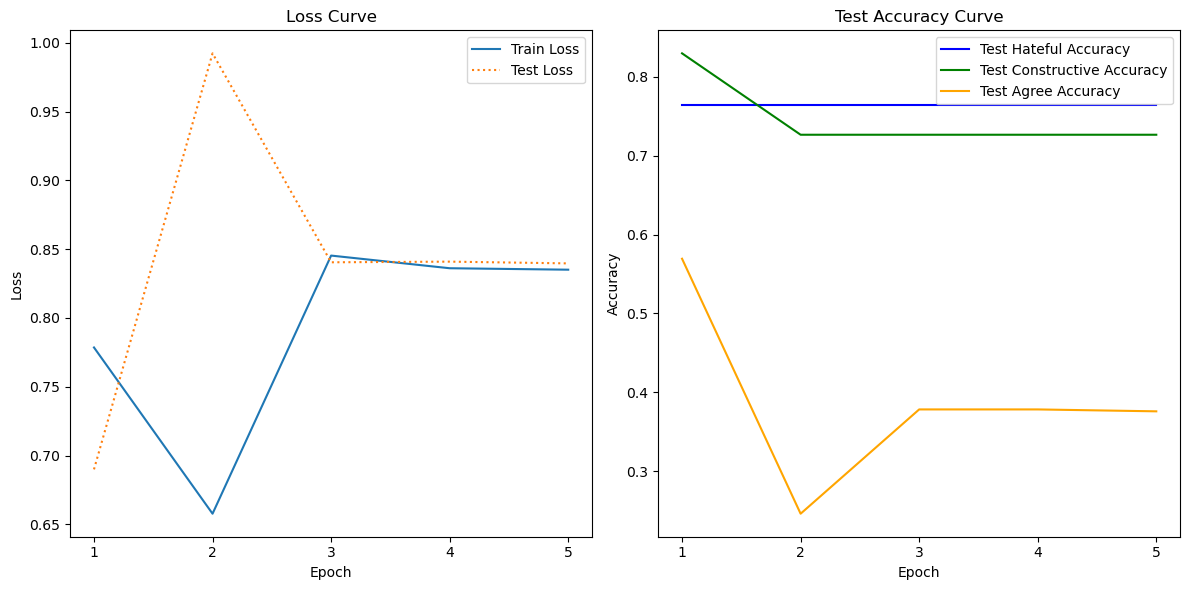

In [3]:
# Code implementing the new custom class model
# It seems the idea of customizing the roberta model is to prevent overfitting by implementing dropout layers, doesnt seem to change very much though


## --- Imports ---

# Data processing 
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# Modelling 
from transformers import AutoTokenizer, AutoModelForSequenceClassification, XLMRobertaModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F


## --- Word definitions ---

# Class: refers to the different ''categories'' of the data. In this case there are 3 classes: 'rep_hateful', 'rep_constructive', 'rep_agree'
# Label: refers to the type of each class. In this case there are 9 labels in total, where a text can have only 1 label for each class, e.g. 'Hateful', 'Not Constructive', 'Disagree'. Thus a text cannot have both the labels 'Hateful' AND 'Not Hateful'!
# Task: refers to the job of solving the classification for each class. In this case the code solves 3 different tasks: 1 is classifying the class 'rep_hateful', 1 for 'rep_constructive' etc.


# Set device, run on gpu if available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the train and test CSV files
train_df = pd.read_csv('/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/train/train_data_ref.csv')
test_df = pd.read_csv('/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Data/test/test_data_ref.csv')


# Set tokenizer and batch size
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
batch_size = 32 # Larger batch size: get more “accurate” gradients since optimizing the loss simultaneously over a larger set of texts. However risk of overfitting and slower computing. 32 is a good default size


# Map labels to numeric values for each of the classes 
label_mappings = {
    'rep_hateful': {'Hateful': 0, 'Not Hateful': 1, 'Unclassifiable Hateful': 2},
    'rep_constructive': {'Not Constructive': 0, 'Constructive': 1, 'Unclassifiable Constructive': 2},
    'rep_agree': {'Agree': 0, 'Disagree': 1, 'Unclear': 2}}
for column, mapping in label_mappings.items():
    train_df[column] = train_df[column].map(mapping)
    test_df[column] = test_df[column].map(mapping)


# Directly extract the necessary columns as a numpy array (already encoded as 0, 1, 2)
train_labels = train_df[['rep_hateful', 'rep_constructive', 'rep_agree']].values
test_labels = test_df[['rep_hateful', 'rep_constructive', 'rep_agree']].values


# Define class
class TextDataset(Dataset):
    def __init__(self, texts, ref_texts, labels_hateful, labels_constructive, labels_agree, tokenizer, max_length = 512):
        self.texts = texts
        self.ref_texts = ref_texts
        self.labels_hateful = labels_hateful
        self.labels_constructive = labels_constructive
        self.labels_agree = labels_agree
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts) # Returns the size of the dataset

    def __getitem__(self, idx):
        text = self.texts[idx]
        ref_text = self.ref_texts[idx]
        # Get labels for each class
        label_hateful = self.labels_hateful[idx]
        label_constructive = self.labels_constructive[idx]
        label_agree = self.labels_agree[idx]

        # Tokenize the reply tweet 
        rep_tokens = self.tokenizer.tokenize(text)

        # Determine the maximum length of the reference text that can be used 
        max_ref_length = 511 - len(rep_tokens)

        # Tokenize the reference text and truncate if necessary
        ref_tokens = self.tokenizer.tokenize(ref_text)
        if len(ref_tokens) > max_ref_length:
            truncated_ref_tokens = ref_tokens[-max_ref_length:]
        else:
            truncated_ref_tokens = ref_tokens

        # Combine the reference and reply text tokens with a [SEP] token
        combined_tokens = truncated_ref_tokens + [self.tokenizer.sep_token] + rep_tokens 

        # Convert the combined tokens to a text string
        combined_text = self.tokenizer.convert_tokens_to_string(combined_tokens)
        
        # Encode the combined text
        encoded_data = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True, 
            max_length=512,
            padding='max_length',
            truncation='only_first', 
            return_attention_mask=True, 
            return_tensors='pt')

        # Return input tensors and labels for each class
        return {
            "input_ids": encoded_data["input_ids"].squeeze(),  # Squeeze function converts to the correct shape
            "attention_mask": encoded_data["attention_mask"].squeeze(),
            "labels_hateful": torch.tensor(label_hateful, dtype = torch.long), # Convert labels into tensor format
            "labels_constructive": torch.tensor(label_constructive, dtype = torch.long), # Long function to get 64-bit integer numbers 
            "labels_agree": torch.tensor(label_agree, dtype = torch.long)}


class RobertaForContextualClassification(nn.Module):
    def __init__(self, num_labels):
        super(RobertaForContextualClassification, self).__init__() 
        self.roberta = XLMRobertaModel.from_pretrained('xlm-roberta-large') # Initializes the XLM-RoBERTa model from Hugging Face's transformers library
        self.dropout = nn.Dropout(0.1) # Adds a dropout layer (regularization technique) to to prevent overfitting = 10% of the neurons are randomly deactivated during training
        self.linear = nn.Linear(self.roberta.config.hidden_size, num_labels) # Adds a linear layer that maps hidden size (the output size of the model's hidden representations) to the number of classification labels (num_labels). This linear layer is responsible for producing the logits (predictions) for each class.

    def forward(self, input_ids, attention_mask): 
        # Processes the input IDs and attention mask through the model and returns an output
        output = self.roberta(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    inputs_embeds=None) 

        pooled_output = output[1] # Takes second element of output, the pooled output which is the hidden state of the [CLS] token
        pooled_output = self.dropout(pooled_output) # A dropout layer is applied to reduce overfitting
        logits = self.linear(pooled_output) # The pooled output is then passed through the linear layer, which produces logits for each class.
        return logits
        

# Prepare datasets using the TextDataset class we definedd
train_dataset = TextDataset(
    texts = train_df['rep_text'].tolist(),
    ref_texts = train_df['ref_text'].tolist(),
    labels_hateful = train_labels[:, 0], # Get first column from train_labels array
    labels_constructive = train_labels[:, 1],
    labels_agree = train_labels[:, 2],
    tokenizer = tokenizer)

test_dataset = TextDataset(
    texts = test_df['rep_text'].tolist(),
    ref_texts = test_df['ref_text'].tolist(),
    labels_hateful = test_labels[:, 0], # Get first column from train_labels array
    labels_constructive = test_labels[:, 1],
    labels_agree = test_labels[:, 2],
    tokenizer = tokenizer)


# Create train and test dataloaders
# Dataset stores the texts and their corresponding labels
# DataLoader wraps an iterable around the Dataset to enable easy access to the texts
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)


# Set model
model = RobertaForContextualClassification(num_labels=9) 
# Set criterion: CrossEntropyLoss used for multi output classification
# This criterion computes the cross entropy loss between input logits and target
criterion = nn.CrossEntropyLoss()
# Set optimizer, Adam works well for most tasks
optimizer = optim.AdamW(model.parameters(), lr = 2e-5) # Small learning rate 0.00002 (2e-5) will ensure that the weights of our large pre-trained model dont change too drastically
# A too high lr (e.g. 0.005) will lead to poor results, causing the model to overshoot/fail to converge/generalize poorly


# Define training process. The model is set up as a multi-output classification task where each label is independently predicted
def train(model, dataloader, criterion, optimizer, device):
    model.train() # Set to train mode
    model.to(device) # Allocate model to defined device 
    
    total_loss = 0.0  # Initialize counter for total_loss as a float
    correct_hateful, correct_constructive, correct_agree = 0, 0, 0 # Initialize counter for correctly predicted labels for each class
    total_hateful, total_constructive, total_agree = 0, 0, 0 # Initialize counter for total number of labels for each class
    
    for batch in tqdm(dataloader, desc = "Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_hateful = batch["labels_hateful"].to(device)
        labels_constructive = batch["labels_constructive"].to(device)
        labels_agree = batch["labels_agree"].to(device)
        
        # Clear out the gradients of all parameters that the optimizer is tracking
        optimizer.zero_grad()
        
        # Calling the custom class model which returns the logits 
        # Logits (raw predictions before applying any activation function) will have a shape of [batch_size, 9] since num_labels = 9
        logits = model(input_ids, attention_mask=attention_mask) 
        

        # Now fetch the logits for each label
        # Split the logits into 3 sets of logits (each corresponding to 1 task with 3 labels)
        logits_hateful = logits[:, :3]           # First 3 logits for the "hateful" task
        logits_constructive = logits[:, 3:6]     # Next 3 logits for the "constructive" task
        logits_agree = logits[:, 6:]             # Last 3 logits for the "agree" task

        # Calculate the loss for each class
        # The criterion (CrossEntropyLoss) applies the softmax function internally to the logits. This transforms the raw logits into probabilities that sum to 1 for each example in the batch. 
        # It then calculates the negative log-likelihood loss based on the true labels
        loss_hateful = criterion(logits_hateful, labels_hateful)
        loss_constructive = criterion(logits_constructive, labels_constructive)
        loss_agree = criterion(logits_agree, labels_agree)

        # Combine the losses (average them)
        loss = (loss_hateful + loss_constructive + loss_agree) / 3.0
        
        # Accumulate the loss as a Python float
        total_loss += loss.item()
        
        # Backward pass and optimizer step
        loss.backward()
        optimizer.step() # Makes the optimizer iterate over all parameters (tensors) it is supposed to update and use their internally stored gradients to update their values.


        # Accuracy calculations
        # Predicts the labels for each task by selecting the label with the highest score (logit)
        preds_hateful = torch.argmax(logits_hateful, dim = 1)
        preds_constructive = torch.argmax(logits_constructive, dim = 1)
        preds_agree = torch.argmax(logits_agree, dim = 1)

        # Calculates how many of the predicted labels are correct and then adds that number to the correct_x counter
        correct_hateful += (preds_hateful == labels_hateful).sum().item()
        correct_constructive += (preds_constructive == labels_constructive).sum().item()
        correct_agree += (preds_agree == labels_agree).sum().item()

        # Keeps track of the total number of texts for each classification task
        total_hateful += labels_hateful.size(0) 
        total_constructive += labels_constructive.size(0)
        total_agree += labels_agree.size(0)

    # Calculate average loss for the train data
    avg_loss_train = total_loss / len(dataloader)

    # Calculate accuracy for each task based on number of correctly predicted 
    accuracy_hateful = correct_hateful / total_hateful
    accuracy_constructive = correct_constructive / total_constructive
    accuracy_agree = correct_agree / total_agree

    return avg_loss_train, accuracy_hateful, accuracy_constructive, accuracy_agree

    
# Define evaluation process
def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set to evaluation mode
    model.to(device) # Allocate model to defined device 
    
    total_loss = 0.0  # Initialize counter for total_loss as a float
    correct_hateful, correct_constructive, correct_agree = 0, 0, 0  # Initialize counter for correctly predicted labels for each class
    total_hateful, total_constructive, total_agree = 0, 0, 0 # Initialize counter for total number of labels for each class

    # Initalize empty list to store predicted labels and true labels
    # These will be used in making the classfication reports
    all_preds_hateful, all_preds_constructive, all_preds_agree = [], [], [] 
    all_labels_hateful, all_labels_constructive, all_labels_agree = [], [], []

    with torch.no_grad(): # Temporarily disable gradient calculations during the forward pass
        # Saves memory and computation because the operations don't need to be tracked for backward propagation.
        # This is crucial during evaluation (inference) because we don't need to update the model parameters—just forward pass predictions.
        for batch in tqdm(dataloader, desc = "Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels_hateful = batch["labels_hateful"].to(device)
            labels_constructive = batch["labels_constructive"].to(device)
            labels_agree = batch["labels_agree"].to(device)

            # Calling the custom class model which returns the logits 
            # Logits (raw predictions before applying any activation function) will have a shape of [batch_size, 9] since num_labels = 9
            logits = model(input_ids, attention_mask=attention_mask) 

            # Split the logits for each task
            logits_hateful = logits[:, :3]          
            logits_constructive = logits[:, 3:6] 
            logits_agree = logits[:, 6:]

            # Calculate loss for each task
            loss_hateful = criterion(logits_hateful, labels_hateful)
            loss_constructive = criterion(logits_constructive, labels_constructive)
            loss_agree = criterion(logits_agree, labels_agree)

            # Combine the losses (average them) and store as float
            loss = (loss_hateful + loss_constructive + loss_agree) / 3.0
            total_loss += loss.item()

            # Predicts the labels for each task
            preds_hateful = torch.argmax(logits_hateful, dim=1).cpu().numpy()
            preds_constructive = torch.argmax(logits_constructive, dim=1).cpu().numpy()
            preds_agree = torch.argmax(logits_agree, dim=1).cpu().numpy()

            # Extend the predictions and true labels
            all_preds_hateful.extend(preds_hateful)
            all_preds_constructive.extend(preds_constructive)
            all_preds_agree.extend(preds_agree)

            all_labels_hateful.extend(labels_hateful.cpu().numpy()) # Use labels on CPU for comparison after moving them to device
            all_labels_constructive.extend(labels_constructive.cpu().numpy())
            all_labels_agree.extend(labels_agree.cpu().numpy())

            # Update counts for correctly predicted labels 
            correct_hateful += (preds_hateful == labels_hateful.cpu().numpy()).sum()
            correct_constructive += (preds_constructive == labels_constructive.cpu().numpy()).sum()
            correct_agree += (preds_agree == labels_agree.cpu().numpy()).sum()

            # Update counts for total number of labels for each class 
            total_hateful += labels_hateful.size(0)
            total_constructive += labels_constructive.size(0)
            total_agree += labels_agree.size(0)

    # Calculate average loss for the test data
    avg_loss_test = total_loss / len(dataloader)

    # Calculate accuracy for each task based on number of correctly predicted 
    accuracy_hateful = correct_hateful / total_hateful
    accuracy_constructive = correct_constructive / total_constructive
    accuracy_agree = correct_agree / total_agree

    return (avg_loss_test, 
            np.array(all_labels_hateful), np.array(all_preds_hateful),
            np.array(all_labels_constructive), np.array(all_preds_constructive),
            np.array(all_labels_agree), np.array(all_preds_agree),
            accuracy_hateful, accuracy_constructive, accuracy_agree)


# Call device
model = model.to(device)

# --- Setup saving parameters ---

output_dir = "/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Output/model_with_reference/"

# Define a path to save the model checkpoints
checkpoint_dir = "/work/IdaHeleneDencker#2808/Redoing_counterspeech_classifier/Output/model_with_reference/checkpoints/"

# Define the model checkpoint file format (e.g., "model_epoch_{epoch}.pt")
checkpoint_filename = "model_epoch_{epoch}.pt"



## --- Running model ---

# Define the label classes
label_classes = { 
    'rep_hateful': ['Hateful', 'Not Hateful', 'Unclassifiable Hateful'],
    'rep_constructive': ['Constructive', 'Not Constructive', 'Unclassifiable Constructive'],
    'rep_agree': ['Agree', 'Disagree', 'Unclear']
}

train_losses, test_losses = [], [] # Empty lists for storing losses
train_accuracies, test_accuracies = [], [] # Empty lists for storing accuracies

# Number of epochs
num_epochs = 5 #(starts overfitting (increase in loss + decrease in accuracy) after 4 epochs)
# Continued epochs may well increase training accuracy, but this doesn't necessarily mean the model's predictions from new data will be accurate – often it actually gets worse.
# Initialize counter for epoch number
epoch_no = 0 

for epoch in range(num_epochs):
    epoch_no = epoch + 1
    print(f"Epoch {epoch_no}:")

    # -- Train model -- 
    avg_loss_train, train_acc_hateful, train_acc_constructive, train_acc_agree = train(model, train_dataloader, criterion, optimizer, device)
    train_losses.append(avg_loss_train) # Store training loss
    train_accuracies.append((train_acc_hateful, train_acc_constructive, train_acc_agree)) # Store accuracies for training
    
    # Save model checkpoint
    checkpoint_path = checkpoint_dir + checkpoint_filename.format(epoch = epoch_no)
    torch.save(model.state_dict(), checkpoint_path)
    
    # -- Test model -- 
    avg_loss_test, test_true_labels_hateful, test_pred_labels_hateful,test_true_labels_constructive, test_pred_labels_constructive, test_true_labels_agree, test_pred_labels_agree, test_acc_hateful, test_acc_constructive, test_acc_agree =  evaluate(model, test_dataloader, criterion, device)
    test_losses.append(avg_loss_test) # Store test loss
    test_accuracies.append((test_acc_hateful, test_acc_constructive, test_acc_agree)) # Store accuracies for testing

    # Generate confusion matrix for each class
    for class_name, labels in label_classes.items():
        if class_name == 'rep_hateful':
            class_true = test_true_labels_hateful
            class_pred = test_pred_labels_hateful
        elif class_name == 'rep_constructive':
            class_true = test_true_labels_constructive
            class_pred = test_pred_labels_constructive
        elif class_name == 'rep_agree':
            class_true = test_true_labels_agree
            class_pred = test_pred_labels_agree
            
        # Compute the confusion matrix 
        matrix = confusion_matrix(class_true, class_pred)

        # Plot and save the confusion matrix
        plt.figure(figsize = (10,10))
        sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Blues',
                     xticklabels = labels,
                     yticklabels = labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for {class_name}')
        plt.savefig(f'{output_dir}/confusion_matrix_{class_name}.png')
        plt.close()

    # Generate classification report for each class
    for label in ['constructive', 'agree', 'hateful']:
        if label == 'constructive':
            true_labels = test_true_labels_constructive
            pred_labels = test_pred_labels_constructive
        elif label == 'agree':
            true_labels = test_true_labels_agree
            pred_labels = test_pred_labels_agree
        else:
            true_labels = test_true_labels_hateful
            pred_labels = test_pred_labels_hateful

        report = classification_report(true_labels, 
                                       pred_labels,
                                       target_names = label_classes[f'rep_{label}'], 
                                       output_dict = True)
        
        report_name = output_dir + f"classification_report_{label}_{epoch_no}.txt"
        with open(report_name, "w") as f:
            f.write(classification_report(
                true_labels, pred_labels,
                target_names=label_classes[f'rep_{label}']))

    # Print results 
    print(f"  Train Loss: {avg_loss_train:.4f}, test Loss: {avg_loss_test:.4f}")
    print(f"  Hateful Accuracy: {test_acc_hateful:.4f}, Constructive Accuracy: {test_acc_constructive:.4f}, Agree Accuracy: {test_acc_agree:.4f}")
    print("  Average Accuracy :", round((test_acc_hateful+test_acc_constructive + test_acc_agree)/3,3))



# --- Plotting results ---

plt.figure(figsize = (12,6))

# Loss curve
plt.subplot(1,2,1)
plt.plot(np.arange(1, num_epochs+1), train_losses, label = "Train Loss")
plt.plot(np.arange(1, num_epochs+1), test_losses, label = "Test Loss", linestyle = ":")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(np.arange(1, num_epochs+1)) #show x-axis as integers

# Accuracy on test set (colored by class)
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, num_epochs+1), [x[0] for x in test_accuracies], label = "Test Hateful Accuracy", color = "blue")
plt.plot(np.arange(1, num_epochs+1), [x[1] for x in test_accuracies], label = "Test Constructive Accuracy", color = "green")
plt.plot(np.arange(1, num_epochs+1), [x[2] for x in test_accuracies], label = "Test Agree Accuracy", color = "orange")
plt.title("Test Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(np.arange(1, num_epochs+1)) #show x-axis as integers

# Save and show 
plt.savefig(output_dir+'accuracy_and_loss_curce_plot.png')
plt.tight_layout()
plt.show()

